### Capstone Project - Short term rental 



### The Data

The dataset below is from [opendatasoft]() and contains short temm rentals listings for the city of san franscisco. A business model to predict on the listing price of a short term rental property.


## Approach
1. Create a regression model to estimate the best short term house listing price
2. Save the model
3. Deploy the model
4. Setup api interface to the model
5. Develop a web application to access the model

In [667]:
import pandas as pd
import numpy as np
from numpy import random
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import time

# Step 1: Load dataset

In [668]:
listings= pd.read_csv("SF_airbnb-listings.csv",dtype={"State": "string","Zipcode":"string"})

# Step 2: Explore dataset

In [669]:
# Dataset dimensions 
listings.shape

(8680, 89)

In [670]:
# Display listings columns
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8680 entries, 0 to 8679
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              8680 non-null   int64  
 1   Listing Url                     8680 non-null   object 
 2   Scrape ID                       8680 non-null   int64  
 3   Last Scraped                    8680 non-null   object 
 4   Name                            8680 non-null   object 
 5   Summary                         8409 non-null   object 
 6   Space                           6205 non-null   object 
 7   Description                     8678 non-null   object 
 8   Experiences Offered             8680 non-null   object 
 9   Neighborhood Overview           5170 non-null   object 
 10  Notes                           4125 non-null   object 
 11  Transit                         5436 non-null   object 
 12  Access                          53

In [671]:
# Peak at the data
listings.head(5)

ID                            Listing Url       Scrape ID  \
0   9316519   https://www.airbnb.com/rooms/9316519  20170401232214   
1  11461771  https://www.airbnb.com/rooms/11461771  20170401232214   
2    910338    https://www.airbnb.com/rooms/910338  20170401232214   
3   4902729   https://www.airbnb.com/rooms/4902729  20170401232214   
4  15342398  https://www.airbnb.com/rooms/15342398  20170401232214   

  Last Scraped                                               Name  \
0   2017-04-02                Central Dwntwn USq Studio Timeshare   
1   2017-04-02  Startup Basecamp,org The First Startup Hotel (#3)   
2   2017-04-02                 Cute, sunny studio right downtown!   
3   2017-04-02                 Private Room Near Downtown SF (15)   
4   2017-04-02  1bdrm Wyndham Canterbury*SPECIAL BOOK NOW PRIC...   

                                             Summary  \
0  The Donatello is a timeshare/hotel which is on...   
1  We are much more than just an affordable, qual...   
2  Fully furnished studio with all amenities you ...   
3  Come stay in a dorm like style apartment. A pr...   
4  Once you settle in, you’ll find that San Franc...   

                                               Space  \
0  DESCRIPTION With 400 square feet of space and ...   
1  This listing price is for Double Occupancy Roo...   
2  Apartment is a quiet, fully furnished studio i...   
3  The apartment located at the heart of San Fran...   
4  Spacious living rooms with large-screen TV, DV...   

                                         Description Experiences Offered  \
0  The Donatello is a timeshare/hotel which is on...                none   
1  We are much more than just an affordable, qual...                none   
2  Fully furnished studio with all amenities you ...                none   
3  Come stay in a dorm like style apartment. A pr...                none   
4  Once you settle in, you’ll find that San Franc...                none   

                               Neighborhood Overview  ...  \
0  Lunch at the Rotunda Restaurant in Nieman Marc...  ...   
1  Startup Basecamp is conveniently located in th...  ...   
2  There are tons of places to eat and have a dri...  ...   
3  Although the City is big the neighborhood has ...  ...   
4  At the heart of downtown in one of the most dy...  ...   

  Review Scores Communication Review Scores Location Review Scores Value  \
0                        10.0                   10.0                10.0   
1                         9.0                    7.0                 8.0   
2                         9.0                   10.0                 9.0   
3                        10.0                    8.0                 9.0   
4                        10.0                   10.0                10.0   

  License Jurisdiction Names Cancellation Policy  \
0     NaN      SAN FRANCISCO              strict   
1     NaN      SAN FRANCISCO              strict   
2     NaN      SAN FRANCISCO              strict   
3     NaN      SAN FRANCISCO            moderate   
4     NaN      SAN FRANCISCO              strict   

  Calculated host listings count Reviews per Month  \
0                             41              0.13   
1                              4              0.53   
2                              1              3.85   
3                              7              3.98   
4                              7              0.68   

                               Geolocation  \
0  37.786982310172775, -122.40918627238219   
1    37.7820790542682, -122.42177467327625   
2   37.78715483357885, -122.41190091005494   
3   37.78468410132785, -122.41481199457196   
4  37.788086767196674, -122.41195846653257   

                                            Features  
0  Host Has Profile Pic, Host Identity Verified, ...  
1  Host Has Profile Pic, Host Identity Verified, ...  
2  Host Has Profile Pic, Host Identity Verified, ...  
3  Host Has Profile Pic, Host Identity Verified, ...  
4  Host Has Profile Pic, Hos

In [672]:
# Describe the various columns of the dataset
listings.describe()

ID     Scrape ID       Host ID  Host Response Rate  \
count  8.680000e+03  8.680000e+03  8.680000e+03         5957.000000   
mean   8.912386e+06  2.017040e+13  2.325039e+07           94.346651   
std    5.411146e+06  8.203598e-02  2.817486e+07           16.085918   
min    9.580000e+02  2.017040e+13  4.600000e+01            0.000000   
25%    4.125074e+06  2.017040e+13  3.243848e+06           99.000000   
50%    9.152642e+06  2.017040e+13  1.079851e+07          100.000000   
75%    1.367685e+07  2.017040e+13  3.407492e+07          100.000000   
max    1.800883e+07  2.017040e+13  1.233930e+08          100.000000   

       Host Acceptance Rate  Host Listings Count  Host Total Listings Count  \
count                   0.0          8672.000000                8672.000000   
mean                    NaN             6.091790                   6.091790   
std                     NaN            36.652761                  36.652761   
min                     NaN             0.000000                   0.000000   
25%                     NaN             1.000000                   1.000000   
50%                     NaN             1.000000                   1.000000   
75%                     NaN             2.000000                   2.000000   
max                     NaN          1114.000000                1114.000000   

       Neighbourhood Group Cleansed     Latitude    Longitude  ...  \
count                           0.0  8680.000000  8680.000000  ...   
mean                            NaN    37.767812  -122.430244  ...   
std                             NaN     0.021854     0.025478  ...   
min                             NaN    37.708293  -122.511500  ...   
25%                             NaN    37.753386  -122.442000  ...   
50%                             NaN    37.769862  -122.425406  ...   
75%                             NaN    37.785543  -122.412447  ...   
max                             NaN    37.831093  -122.364759  ...   

       Number of Reviews  Review Scores Rating  Review Scores Accuracy  \
count        8680.000000           6634.000000             6619.000000   
mean           24.879724             94.533464                9.652364   
std            45.217652              7.555903                0.766388   
min             0.000000             20.000000                2.000000   
25%             1.000000             93.000000                9.000000   
50%             6.000000             97.000000               10.000000   
75%            27.000000            100.000000               10.000000   
max           488.000000            100.000000               10.000000   

       Review Scores Cleanliness  Review Scores Checkin  \
count                6622.000000            6611.000000   
mean                    9.486409               9.803509   
std                     0.908624               0.586763   
min                     2.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       Review Scores Communication  Review Scores Location  \
count                  6623.000000             6612.000000   
mean                      9.799638                9.562613   
std                       0.598387                0.778150   
min                       2.000000                2.000000   
25%                      10.000000                9.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       Review Scores Value  Calculated host listings count  Reviews per Month  
count          6609.000000                     8680.000000        6722.000000  
mean              9.375548                        2.728111           1.668529  
std               0.841376          

In [673]:
# Compute the missing count and percentage of every column
def Missing_Column_Value(df):
    columns_with_null_values = 0
    missing = pd.DataFrame(columns=['Column_Name','Null_Count','Null_Count_Percentage'])
    missing['Column_Name'] = []
    missing['Null_Count'] = []
    missing['Null_Count_Percentage'] = []
    
    for col in df.columns:
        #missing_vals = df[col].isnull().sum()
        #mean = sum / total
        #pct = df[col].isnull().mean() * 100 
        if df[col].isnull().sum() != 0:
            print('{} == {} [{}%]'.format(col, df[col].isnull().sum(), round(df[col].isnull().mean() * 100, 2)))
            
        columns_with_null_values += df[col].isnull().sum()
    
    if columns_with_null_values == 0:
        print("no missing values")


In [674]:
# Calculate columns with missing value
Missing_Column_Value(listings)

Summary == 271 [3.12%]
Space == 2475 [28.51%]
Description == 2 [0.02%]
Neighborhood Overview == 3510 [40.44%]
Notes == 4555 [52.48%]
Transit == 3244 [37.37%]
Access == 3347 [38.56%]
Interaction == 3567 [41.09%]
House Rules == 2838 [32.7%]
Thumbnail Url == 1471 [16.95%]
Medium Url == 1471 [16.95%]
Picture Url == 7 [0.08%]
XL Picture Url == 1471 [16.95%]
Host Name == 8 [0.09%]
Host Since == 8 [0.09%]
Host Location == 30 [0.35%]
Host About == 2775 [31.97%]
Host Response Time == 2723 [31.37%]
Host Response Rate == 2723 [31.37%]
Host Acceptance Rate == 8680 [100.0%]
Host Thumbnail Url == 8 [0.09%]
Host Picture Url == 8 [0.09%]
Host Neighbourhood == 737 [8.49%]
Host Listings Count == 8 [0.09%]
Host Total Listings Count == 8 [0.09%]
Host Verifications == 5 [0.06%]
Neighbourhood == 916 [10.55%]
Neighbourhood Group Cleansed == 8680 [100.0%]
Zipcode == 109 [1.26%]
Market == 32 [0.37%]
Bathrooms == 36 [0.41%]
Bedrooms == 8 [0.09%]
Beds == 17 [0.2%]
Amenities == 73 [0.84%]
Square Feet == 8496 [97.

In [675]:
# Non unique count
listings.nunique()

ID                                8680
Listing Url                       8680
Scrape ID                            1
Last Scraped                         1
Name                              8552
                                  ... 
Cancellation Policy                  5
Calculated host listings count      21
Reviews per Month                  727
Geolocation                       8680
Features                            49
Length: 89, dtype: int64

In [676]:
# Check whether there are any duplicate samples
listings.duplicated().sum()

0

# Step 3: Data Preprocessing

In [678]:
# Normalize the column name - Replace space with underscore and convert to lowercase
listings.columns = [col.lower().replace(" ","_") for col in listings.columns]

In [679]:
# Count on non unique hosts
listings["host_id"].nunique()

6899

In [680]:
desc = pd.DataFrame(index = list(listings))
desc['count'] = listings.count()
desc['nunique'] =listings.nunique()
desc['%unique'] = desc['nunique'] / len(listings) * 100
desc['null'] = listings.isnull().sum()
desc['%null'] = desc['null'] / len(listings) * 100
desc['type'] = listings.dtypes
desc = pd.concat([desc, listings.describe().T.drop('count', axis = 1)], axis = 1)
desc

count  nunique     %unique  null      %null  \
id                               8680     8680  100.000000     0   0.000000   
listing_url                      8680     8680  100.000000     0   0.000000   
scrape_id                        8680        1    0.011521     0   0.000000   
last_scraped                     8680        1    0.011521     0   0.000000   
name                             8680     8552   98.525346     0   0.000000   
...                               ...      ...         ...   ...        ...   
cancellation_policy              8680        5    0.057604     0   0.000000   
calculated_host_listings_count   8680       21    0.241935     0   0.000000   
reviews_per_month                6722      727    8.375576  1958  22.557604   
geolocation                      8680     8680  100.000000     0   0.000000   
features                         8678       49    0.564516     2   0.023041   

                                   type          mean           std  \
id                                int64  8.912386e+06  5.411146e+06   
listing_url                      object           NaN           NaN   
scrape_id                         int64  2.017040e+13  8.203598e-02   
last_scraped                     object           NaN           NaN   
name                             object           NaN           NaN   
...                                 ...           ...           ...   
cancellation_policy              object           NaN           NaN   
calculated_host_listings_count    int64  2.728111e+00  7.131478e+00   
reviews_per_month               float64  1.668529e+00  3.236830e+00   
geolocation                      object           NaN           NaN   
features                         object           NaN           NaN   

                                         min           25%           50%  \
id                              9.580000e+02  4.125074e+06  9.152642e+06   
listing_url                              NaN           NaN           NaN   
scrape_id                       2.017040e+13  2.017040e+13  2.017040e+13   
last_scraped                             NaN           NaN           NaN   
name                                     NaN           NaN           NaN   
...                                      ...           ...           ...   
cancellation_policy                      NaN           NaN           NaN   
calculated_host_listings_count  1.000000e+00  1.000000e+00  1.000000e+00   
reviews_per_month               1.000000e-02  3.100000e-01  9.800000e-01   
geolocation                              NaN           NaN           NaN   
features                                 NaN           NaN           NaN   

                                         75%           max  
id                              1.367685e+07  1.800883e+07  
listing_url                              NaN           NaN  
scrape_id                       2.017040e+13  2.017040e+13  
last_scraped                             NaN           NaN  
name                                     NaN           NaN  
...                                      ...           ...  
cancellation_policy                      NaN           NaN  
calculated_host_listings_count  2.000000e+00  6.900000e+01  
reviews_per_month               2.420000e+00  2.230000e+02  
geolocation                              NaN           NaN  
features                                 NaN           NaN  

[89 rows x 13 columns]

In [635]:
listings.isnull().sum()

id                                   0
listing_url                          0
scrape_id                            0
last_scraped                         0
name                                 0
                                  ... 
cancellation_policy                  0
calculated_host_listings_count       0
reviews_per_month                 1958
geolocation                          0
features                             2
Length: 89, dtype: int64

In [637]:
listings[['street','city','state','zipcode','country']].isnull().sum()

street       0
city         0
state        0
zipcode    109
country      0
dtype: int64

In [638]:
null_rows = listings.loc[  listings['street'].isnull() 
                         | listings['city'].isnull() 
                         | listings['state'].isnull()
                         | listings['zipcode'].isnull()
                         | listings['country'].isnull()]

print(null_rows[['street','city','state','zipcode','country']])

                                                 street           city state  \
64                     San Francisco, CA, United States  San Francisco    CA   
167                    San Francisco, CA, United States  San Francisco    CA   
239                    San Francisco, CA, United States  San Francisco    CA   
261   Mission District, San Francisco, CA, United St...  San Francisco    CA   
287                    San Francisco, CA, United States  San Francisco    CA   
...                                                 ...            ...   ...   
8288                   San Francisco, CA, United States  San Francisco    CA   
8293                   San Francisco, CA, United States  San Francisco    CA   
8499                   San Francisco, CA, United States  San Francisco    CA   
8554                   San Francisco, CA, United States  San Francisco    CA   
8560                   San Francisco, CA, United States  San Francisco    CA   

     zipcode        country  
64      <

In [639]:
listings['street'].unique()

array(['Downtown, San Francisco, CA 94102, United States',
       'Western Addition/NOPA, San Francisco, CA 94109, United States',
       'Downtown, San Francisco, CA 94109, United States',
       'Tenderloin, San Francisco, CA 94109, United States',
       'Union Square, San Francisco, CA 94102, United States',
       'Nob Hill, San Francisco, CA 94108, United States',
       'Western Addition/NOPA, San Francisco, CA 94102, United States',
       'Lakeshore, San Francisco, CA 94132, United States',
       'Russian Hill, San Francisco, CA 94109, United States',
       "Fisherman's Wharf, San Francisco, CA 94109, United States",
       'North Beach, San Francisco, CA 94133, United States',
       'Excelsior, San Francisco, CA 94112, United States',
       'San Francisco, CA 94134, United States',
       'Parkside, San Francisco, CA 94116, United States',
       'Outer Sunset, San Francisco, CA 94116, United States',
       'San Francisco, CA 94105, United States',
       'Financial Dist

In [640]:
#street name contains the complete address. Extract just the street name

listings['street']=listings['street'].str.split(', ', expand=True)[0]

In [641]:
listings['street'].value_counts()

Mission District           962
San Francisco              934
Western Addition/NOPA      467
SoMa                       456
Richmond District          438
                          ... 
Soma                         3
Presidio                     1
Daly City                    1
10 min walk to Dogpatch      1
Fillmore District            1
Name: street, Length: 62, dtype: int64

In [642]:
#print(np.where(listings['street']=='10 min walk to Dogpatch' )[0][0])
#listings.drop([np.where(listings['street']=='10 min walk to Dogpatch')[0][0]], axis=0, inplace=True)

In [643]:
# Display unique zipcodes
listings['zipcode'].unique()

<StringArray>
[       '94102',        '94109',        '94108',        '94132',
        '94133',        '94112',        '94134',        '94116',
        '94105',        '94111',        '94107',        '94110',
        '94117',        '94115',        '94121',        '94114',
        '94131',           <NA>,        '94122',        '94130',
        '94103',        '94118',        '94123',        '94124',
        '94158',        '94127',        '94104',   '94107-1273',
        '94129',        '94401', '94158\n94158']
Length: 31, dtype: string

In [644]:
# cleanup zipcode
listings['zipcode']=listings['zipcode'].str.split('-', expand=True)[0]
listings['zipcode']=listings['zipcode'].str.split('\n', expand=True)[0]

In [645]:
listings['zipcode'].value_counts()

94110    1286
94117     743
94109     738
94114     701
94103     512
94107     469
94115     434
94102     424
94131     355
94123     329
94112     329
94122     328
94118     300
94133     296
94121     241
94108     230
94116     185
94127     129
94105     123
94124     111
94134      97
94132      88
94158      50
94111      27
94130      23
94104      20
94129       2
94401       1
Name: zipcode, dtype: Int64

In [646]:
# Neighbourhood names
listings['neighbourhood_cleansed'].unique()

array(['Downtown/Civic Center', 'Lakeshore', 'Russian Hill', 'Excelsior',
       'Parkside', 'Financial District', 'Ocean View', 'Mission',
       'Western Addition', 'Seacliff', 'Haight Ashbury', 'Outer Mission',
       'Noe Valley', 'Inner Sunset', 'Treasure Island/YBI',
       'Outer Richmond', 'Crocker Amazon', 'Bernal Heights', 'Chinatown',
       'North Beach', 'Nob Hill', 'Inner Richmond', 'Marina', 'Bayview',
       'Pacific Heights', 'Presidio Heights', 'South of Market',
       'Glen Park', 'Potrero Hill', 'Castro/Upper Market', 'Twin Peaks',
       'West of Twin Peaks', 'Outer Sunset', 'Visitacion Valley',
       'Presidio', 'Golden Gate Park', 'Diamond Heights'], dtype=object)

In [654]:
# Listing count for various neighbourhood
listings['neighbourhood_cleansed'].value_counts()

Mission                  1016
Western Addition          755
South of Market           595
Downtown/Civic Center     560
Castro/Upper Market       473
Bernal Heights            445
Haight Ashbury            405
Noe Valley                378
Nob Hill                  314
Marina                    290
Inner Richmond            281
Potrero Hill              276
Outer Sunset              253
Pacific Heights           233
Russian Hill              211
Outer Richmond            192
North Beach               174
Inner Sunset              163
Outer Mission             159
Excelsior                 151
Chinatown                 149
Financial District        134
West of Twin Peaks        121
Parkside                  119
Bayview                   118
Ocean View                104
Twin Peaks                100
Glen Park                  81
Lakeshore                  52
Visitacion Valley          38
Presidio Heights           36
Crocker Amazon             25
Treasure Island/YBI        25
Seacliff  

In [655]:
# Check whether listings doesn't contain price
listings['price'].isna().sum()

0

In [656]:
# Insights on null listing price
listing_price_null_rows = listings.loc[listings['price'].isnull()]

print(null_rows[['price','room_type','beds']])

      price        room_type  beds
64    200.0  Entire home/apt   1.0
167   285.0  Entire home/apt   2.0
239   199.0  Entire home/apt   1.0
261   148.0  Entire home/apt   1.0
287   150.0  Entire home/apt   1.0
...     ...              ...   ...
8288  125.0     Private room   1.0
8293    NaN  Entire home/apt   3.0
8499   79.0  Entire home/apt   1.0
8554  200.0  Entire home/apt   1.0
8560  695.0  Entire home/apt   2.0

[109 rows x 3 columns]


In [657]:
# Display the median listings price
print(listings['price'].median())

155.0


In [658]:
# Delete all listings where listing price = null
listings.dropna(subset=['price'],inplace=True)

In [653]:
listings['security_deposit'].isna().sum() # ok to ignore

5002

In [601]:
# Display unique security deposit amount
listings['security_deposit'].unique()

array([  0., 180., 100.,  95., 500., 250., 150., 200., 400., 300., 350.,
       550., 750., 175., 600., 125., 120., 257., 450., 700., 800., 199.,
       575., 950., 599., 299., 850., 333., 900., 201., 275., 975., 107.,
       650., 475., 185., 190., 165.,  99., 775., 399., 217., 999., 295.,
       220., 325., 298., 380., 390., 315., 555., 225., 499., 666., 335.,
       312., 474., 949., 483., 111., 425., 240., 115., 349., 189., 397.,
       249., 375., 290., 130., 699., 210., 105., 495., 297., 145., 149.,
       680.])

In [602]:
# Display securityDeposit amount count 
listings['security_deposit'].value_counts()

0.0      5177
500.0     910
200.0     520
100.0     488
300.0     406
         ... 
555.0       1
257.0       1
335.0       1
474.0       1
680.0       1
Name: security_deposit, Length: 78, dtype: int64

In [599]:
# Replace nan with 0
listings['security_deposit'] = listings['security_deposit'].fillna(0)

In [603]:
listings['guests_included'].unique()

array([ 1,  2,  5,  4,  6,  3,  8,  7, 10, 12,  9])

In [604]:
listings['extra_people'].isna().sum()

0

In [605]:
listings['extra_people'].unique()

array([  0,  69,  25,  85,  40,   5,  20,  35,  10,  45,  15,  50,  70,
        12, 100,  39,  30,  60,  29,  18,  75,  34,  19,   7, 300,  55,
        28,  11,  47,  65, 175, 150, 200,  21,  33,  49,  79,  80,   8,
        99,  24,   6,  90, 120, 110,   9,  46, 225,  38, 115,  32, 125,
       250, 199,  26,  86,  95,  17, 130,  22,  63,  59,  52,  23,  36,
        27,  37,  72, 165,  42, 215, 179,  48])

In [606]:
listings["property_type"].unique()

array(['Apartment', 'Other', 'Condominium', 'Boutique hotel', 'Timeshare',
       'House', 'Dorm', 'Cabin', 'Boat', 'Townhouse', 'Cave', 'Camper/RV',
       'Loft', 'Bed & Breakfast', 'Hostel', 'Castle', 'Lighthouse',
       'Tent', 'Guesthouse', 'Bungalow', 'Treehouse', 'Villa',
       'Pension (Korea)', 'Yurt'], dtype=object)

In [479]:
# Display propertytype count 
listings['property_type'].value_counts()

Apartment          4905
House              2401
Condominium         527
Loft                132
Other               116
Bed & Breakfast      92
Boutique hotel       65
Dorm                 60
Townhouse            59
Timeshare            40
Guesthouse           22
Hostel               16
Camper/RV            13
Bungalow             11
Cabin                 8
Boat                  5
Lighthouse            3
Treehouse             3
Cave                  1
Castle                1
Tent                  1
Villa                 1
Pension (Korea)       1
Yurt                  1
Name: property_type, dtype: int64

In [480]:
# Delete properties with less than 10 listings
listings = listings.groupby("property_type").filter(lambda x: len(x)>=10)

In [481]:
# Display unique room type
listings["room_type"].unique()

array(['Entire home/apt', 'Shared room', 'Private room'], dtype=object)

In [482]:
# Display roomtype count 
listings['room_type'].value_counts()

Entire home/apt    4876
Private room       3402
Shared room         181
Name: room_type, dtype: int64

In [483]:
# Delete listings if roomtype is null
listings = listings[~pd.isnull(listings["room_type"])]

In [484]:
# Display unique bedrooms
listings["bedrooms"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan,  7.])

In [ ]:
# Display unique bedroom count
listings['bedrooms'].value_counts()

In [413]:
# Set bedroom count to 0, if nan
listings['bedrooms'] = listings['bedrooms'].fillna(0)

In [ ]:
# Display unique bathrooms
listings["bathrooms"].unique()

In [ ]:
# Display unique bathroom count
listings['bathrooms'].value_counts()
#listings['bathrooms'].value_counts()[listings['bathrooms'].unique()].sort_values(ascending=True)

In [ ]:
# Set bathroom count to 0, if nan
listings['bathrooms'] = listings['bathrooms'].fillna(0)

In [ ]:
# Display unique number of beds 
listings['beds'].unique() 

In [ ]:
# Display unique bed count 
listings['beds'].value_counts()

In [411]:
# Set bed count to 0, if nan
listings['beds'] = listings['beds'].fillna(0)

In [ ]:
# Display unique bedtype
listings['bed_type'].unique() 

In [ ]:
# Display unique bedtype count
listings['bed_type'].value_counts()

In [ ]:
# Set bedtype to 0, if nan
listings.dropna(subset = ['bed_type'], inplace=True)

In [ ]:
# Check listings which doesn't have cleaning fee set
listings['cleaning_fee'].isna().sum()

In [409]:
# Set cleaning fee = 0, if not set
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(0)

In [414]:
listings[['price','property_type','room_type','bed_type','beds','bedrooms','bathrooms','square_feet']].isnull().sum()

price               0
property_type       0
room_type           0
bed_type            0
beds                0
bedrooms            0
bathrooms           0
square_feet      8276
dtype: int64

In [416]:
# Display unique accomodation count in a property
listings["accommodates"].unique()

array([ 4, 14,  2,  3,  6,  1,  8,  5,  7, 10,  9, 11, 12, 16, 15])

In [417]:
# Display accomodation count
listings['accommodates'].value_counts()

2     3841
4     1607
1      928
3      681
6      626
5      375
8      184
7      107
10      48
9       26
12      14
14       8
16       7
15       4
11       3
Name: accommodates, dtype: int64

In [418]:
# Delete listing if it accomodates more than 16 people
listings = listings[~pd.isnull(listings["accommodates"])]
# Accommodate maximum 16 people
listings = listings[listings["accommodates"] <= 16]

In [518]:
listings['amenities'] = listings['amenities'].str.lower()
listings['amenities'] = listings['amenities'].str.strip()
#listings['amenities'] = listings['amenities'].str.replace(" ","_")


In [520]:
listings['amenities'] = listings['amenities'].str.lstrip()

In [521]:
# Display amenities provided
listings['amenities'].unique()

array(['tv, cable tv, internet, wireless internet, air conditioning, wheelchair accessible, gym, elevator in building, hot tub, heating, family/kid friendly, smoke detector, carbon monoxide detector, essentials, shampoo, 24-hour check-in, hangers, hair dryer, iron, laptop friendly workspace',
       'tv, cable tv, wireless internet, wheelchair accessible, free parking on premises, doorman, elevator in building, heating, suitable for events, smoke detector, first aid kit, iron, laptop friendly workspace',
       'tv, cable tv, internet, wireless internet, kitchen, elevator in building, buzzer/wireless intercom, heating, washer, dryer, smoke detector, hangers, hair dryer, iron, laptop friendly workspace, translation missing: en.hosting_amenity_49, translation missing: en.hosting_amenity_50',
       ...,
       'tv, cable tv, internet, wireless internet, air conditioning, kitchen, heating, washer, dryer, smoke detector, carbon monoxide detector, first aid kit, fire extinguisher, essential

In [524]:
# list of unique amenities offered various properties
amenities_list = ['tv', 'cable tv','internet','wireless internet','kitchen','breakfast','pets allowed',
                  'buzzer/wireless intercom','air conditioning','private living room','bathtub',
                  'room-darkening shades','game console','wheelchair accessible',
                  'free parking on premises', 'doorman', 'pets live on this property',
                  'dog(s)','Pets allowed','cat(s)',
                  'gym','elevator in building','hot tub','heating','washer','dryer','family/kid friendly',
                  'smoke detector','carbon monoxide detector','first aid kit','fire extinguisher',
                  'essentials','shampoo','24-hour check-in','hangers','hair dryer','safety card',
                  'iron','laptop friendly workspace','self check-in','lockbox', 
                  'wheelchair accessible','lock on bedroom door','private entrance','indoor fireplace',
                  'smoking allowed','doorman entry','suitable for events','pool',
                  'high chair','pack ’n Play/travel crib','keypad','other pet(s)','smartlock']

In [542]:
# Identify available amenities in each property listing, split amenities and add amenity to listings dataframe
listings_copy = listings.copy()

# Create a new column for every amenity
for i in range(len(amenities_list)):
    # for every amenity, set its value to 0
    listings[amenities_list[i]] = 0

# if an amenity exists, set to 1, else retain 0
for i in range(len(listings)):
    if not pd.isnull(listings_copy.loc[listings.index[i]]["amenities"]):
        amenities = listings_copy.loc[listings.index[i]]["amenities"].split(",")
        for amenity in amenities:
            listings.at[listings.index[i], amenity] = 1   

In [543]:
#replace space with underscore in column name
listings.columns = [col.lower().replace(" ","_") for col in listings.columns]

In [561]:
# Display unique property features
listings['features'] = listings['features'].str.lower()
listings['features'] = listings['features'].str.strip()
listings["features"].unique()

array(['host has profile pic, host identity verified, is location exact, require guest phone verification',
       'host has profile pic, host identity verified, is location exact',
       'host has profile pic, host identity verified, is location exact, instant bookable',
       'host has profile pic, is location exact, instant bookable',
       'host is superhost, host has profile pic, host identity verified, is location exact',
       'host has profile pic, is location exact',
       'host has profile pic, host identity verified, is location exact, require guest profile picture, require guest phone verification',
       'host has profile pic, host identity verified, instant bookable',
       'host is superhost, host has profile pic, is location exact',
       'host is superhost, host has profile pic, host identity verified, is location exact, require guest profile picture, require guest phone verification',
       'host has profile pic, host identity verified',
       'host is super

In [570]:
# Unique list of property features
features_list = ['host has profile pic','host identity verified','is location exact',
                 'instant bookable','host is superhost',
                 'require guest phone verification','require guest profile picture','requires license']

In [572]:
# Identify features in each property listing, split features and add feature to listings dataframe

# Create a new column for every feature and set it to 0
listings_copy = listings.copy()
for feature in range(len(features_list)):
    listings[features_list[feature]] = 0

# if a feature available, set to 1, else retain 0
for listing in range(len(listings)):
    if not pd.isnull(listings_copy.loc[listings.index[listing]]["features"]):
        features = listings_copy.loc[listings.index[listing]]["features"].split(",")
        for feature in features:
            listings.at[listings.index[listing], feature] = 1  
            #print(feature)

host has profile pic
 host identity verified
 is location exact
 require guest phone verification
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
 instant bookable
host has profile pic
 host identity verified
 is location exact
host has profile pic
 is location exact
 instant bookable
host is superhost
 host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 is location exact
host has profile pic
 host identity verified
 is location exact
 instant bookable
host has profile pic
 host identity verified
 is location exact
 require guest profile picture
 require guest

host has profile pic
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host is superhost
 host has profile pic
 host identity verified
 is location exact
 instant bookable
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 host identity verified
 is location exact
host has profile pic
 is location exact
host is superhost
 host has profile pic
 host identity verified
 is location exact
host has profile pic
 is location exact
host has profile pic
 host identity verified
 is location exact
 instant bookable
host has pro

In [579]:
##listings[' require guest profile picture'].unique()

array([nan,  1.])

In [580]:
listings.shape

(8680, 333)

In [608]:
print("Unique Score Rating rating")
print(listings['review_scores_rating'].unique())

print("\nUnique Listings Accuracy rating")
print(listings['review_scores_accuracy'].unique())

print("\nUnique cleaniness score values")
print(listings['review_scores_cleanliness'].unique())

print("\nUnique checkin time accuracy score rating")
print(listings['review_scores_checkin'].unique())

print("\nUnique owner communication rating")
print(listings['review_scores_communication'].unique())

print("\nUnique Location accuracy score rating")
print(listings['review_scores_location'].unique())

print("\nOverall rating")
print(listings['review_scores_value'].unique())

Unique Score Rating rating
[100.  83.  88.  89.  40.  nan  93.  96.  84.  94.  60.  92.  98.  95.
  99.  73.  78.  97.  65.  87.  80.  90.  53.  91.  68.  86.  70.  81.
  69.  71.  76.  79.  67.  20.  82.  85.  48.  64.  77.  75.  72.  63.
  50.  74.  30.  62.]

Unique Listings Accuracy rating
[10.  7.  9.  4. nan  6.  8.  5.  2.]

Unique cleaniness score values
[10.  7.  8.  9.  4. nan  6.  3.  2.  5.]

Unique checkin time accuracy score rating
[10.  7.  9.  8. nan  6.  2.  5.  4.]

Unique owner communication rating
[10.  9.  6. nan  8.  2.  7.  5.  4.]

Unique Location accuracy score rating
[10.  7.  8.  4. nan  9.  6.  2.  3.  5.]

Overall rating
[10.  8.  9.  4. nan  6.  7.  2.  5.]


In [102]:
listings['minimum_nights'].isna().sum()

0

In [103]:
# minimum number of rental nights
listings['minimum_nights'].unique()

array([   2,    1,    3,    5,    7,    4,   30,   32,   15,    6,   14,
         12,    8,   29,   21,   20,  100,   89,   31,   10,   16,   90,
         27,   28,   22,   25,   13,  500,  365,   18, 1000,   60,  180,
         24,  120,    9,  140,   17,   11])

In [104]:
# Unique count of minimum nights
listings['minimum_nights'].value_counts()

1       2856
2       2431
3       1458
4        447
30       396
5        298
7        266
6         70
14        54
10        35
15        25
31        18
28        15
21        13
20        12
29        11
25        11
8          9
32         8
12         8
13         6
27         5
22         4
90         4
500        3
9          3
18         2
60         2
180        2
24         2
16         1
89         1
100        1
365        1
1000       1
120        1
140        1
17         1
11         1
Name: minimum_nights, dtype: int64

In [105]:
# If min nights is more than 31 days, set to 31
listings.loc[listings['minimum_nights'] > 31, 'minimum_nights'] = 31

In [106]:
# Unique max number of rentals days available
listings['maximum_nights'].unique()

array([      1125,          7,         14,         25,         29,
             1124,         28,        360,         21,          3,
               35,          1,         90,         30,        365,
               10,         27,          8,         31,        150,
               92,         15,         16,       1825,         20,
                6,        180,        100,          4,          9,
                5,         60,         70,       2922,         22,
               45,        730,         12,        270,         24,
              102,          2,         40,         36,         34,
              300,        350,        120,        200,         50,
               75,         95,         59,         11,         26,
            11111,         32,         41,      10000,        364,
               13,         33,         19,        186,        356,
               23,        321,         89,         17,         18,
              125,         99,       1000,        190,        

In [108]:
# If max mights is more than 365 days, set to 365
listings.loc[listings['maximum_nights'] > 365, 'maximum_nights'] = 365

In [109]:
#listings['amenities'].unique()
listings['minimum_nights'].quantile(90/100)
listings['maximum_nights'].quantile(90/100)

365.0

In [ ]:
listings['availability_365'] = np.where(listings['availability_365']>365, 365, listings['availability_365'])

In [110]:
listings.loc[listings['availability_365'] > 500, 'availability_365'] = 365

In [113]:
analyze = listings.filter(["price","cleaning_fee","minimum_nights","number_of_reviews"],axis=1)
analyze.agg(['min','max','mean', 'median', 'std'])


price  cleaning_fee  minimum_nights  number_of_reviews
min       0.000000      0.000000        1.000000           0.000000
max     999.000000    850.000000       31.000000         488.000000
mean    204.707768     57.032889        4.066604          25.414948
median  155.000000     50.000000        2.000000           6.000000
std     154.456145     57.856873        6.714926          45.593567

In [114]:
analyze.quantile([0.05, 0.25, 0.5, 0.75, 0.95])

price  cleaning_fee  minimum_nights  number_of_reviews
0.05   60.0           0.0             1.0                0.0
0.25  100.0           0.0             1.0                1.0
0.50  155.0          50.0             2.0                6.0
0.75  250.0          90.0             3.0               28.0
0.95  500.0         150.0            30.0              117.0

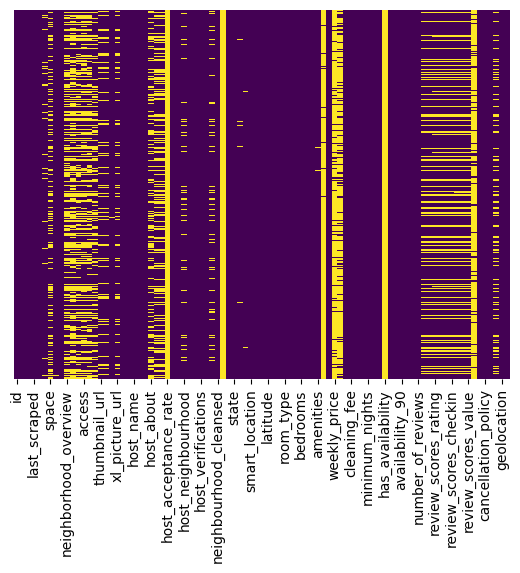

In [117]:
sns.heatmap(listings.isnull(), yticklabels=False, cmap='viridis', cbar=False);

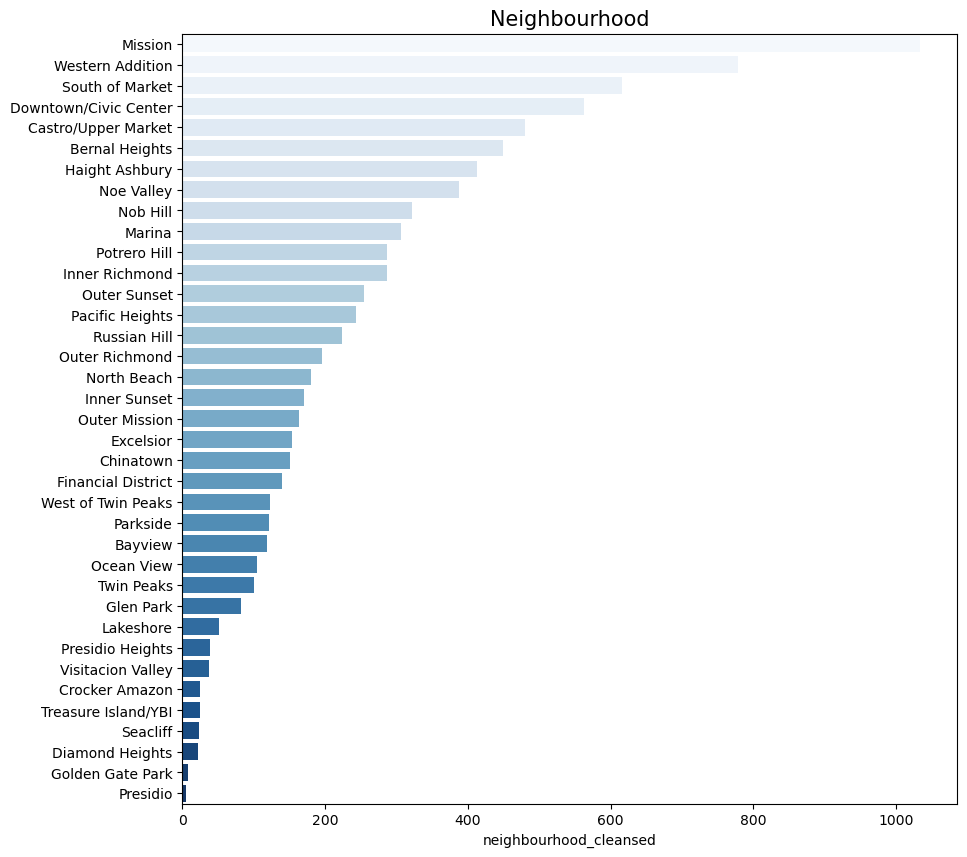

In [687]:
plt.figure(figsize=(10,10))
plt.title("Neighbourhood", size=15, color="Black")
sns.barplot(x=listings['neighbourhood_cleansed'].value_counts(), 
            y=listings['neighbourhood_cleansed'].value_counts().index, palette="Blues")
plt.show()

array([[<AxesSubplot:title={'center':'review_scores_rating'}>,
        <AxesSubplot:title={'center':'review_scores_accuracy'}>,
        <AxesSubplot:title={'center':'review_scores_cleanliness'}>],
       [<AxesSubplot:title={'center':'review_scores_checkin'}>,
        <AxesSubplot:title={'center':'review_scores_communication'}>,
        <AxesSubplot:title={'center':'review_scores_location'}>],
       [<AxesSubplot:title={'center':'review_scores_value'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>,
        <AxesSubplot:>]], dtype=object)

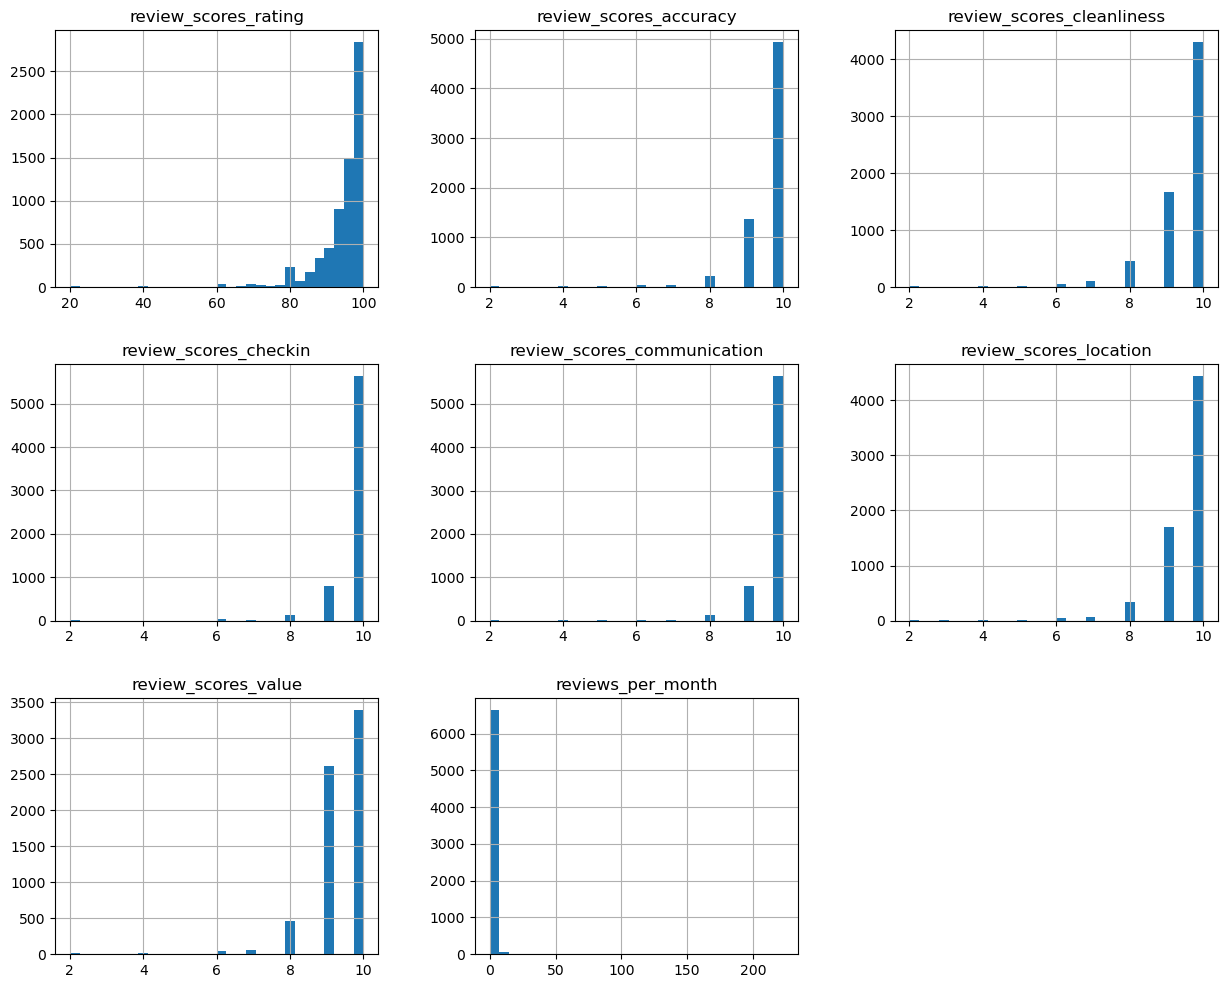

In [699]:
reviews = listings.loc[:, listings.columns[listings.columns.str.startswith('review')]]
reviews.hist(bins = 30, figsize = (15,12))

In [802]:
def bar_chart(column: str):
    count = listings[column].value_counts()
    fig = plt.figure(figsize=(14, 5))
    bar_ax = sns.barplot(x=count.keys(),y=count, palette="Blues") 
    for i in bar_ax.containers:
        bar_ax.bar_label(i,fontsize=10)
    plt.xticks(rotation = 85, fontsize = 12)
    plt.xlabel(f"{column}",  fontsize = 12)
    plt.ylabel("count", fontsize = 12)
    plt.title(f"{column}", fontsize = 14)
    plt.grid()
    plt.show()

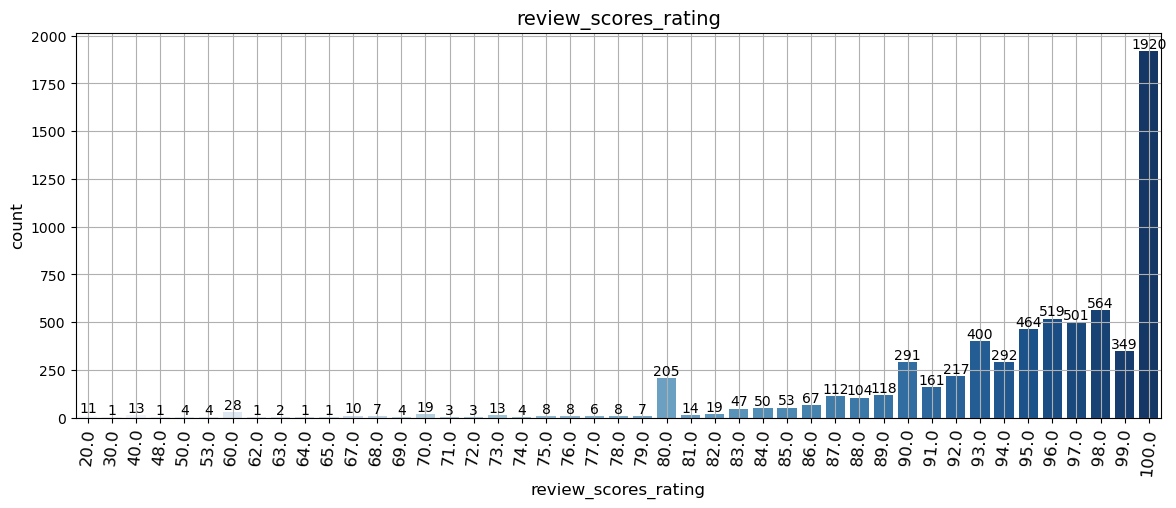

In [803]:
bar_chart(column = "review_scores_rating")

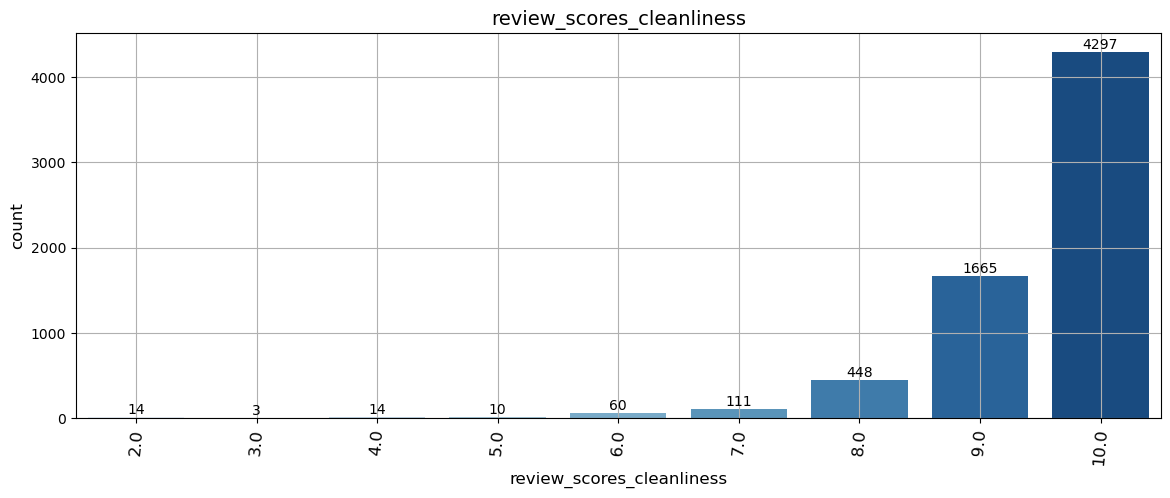

In [804]:
bar_chart(column = "review_scores_cleanliness")

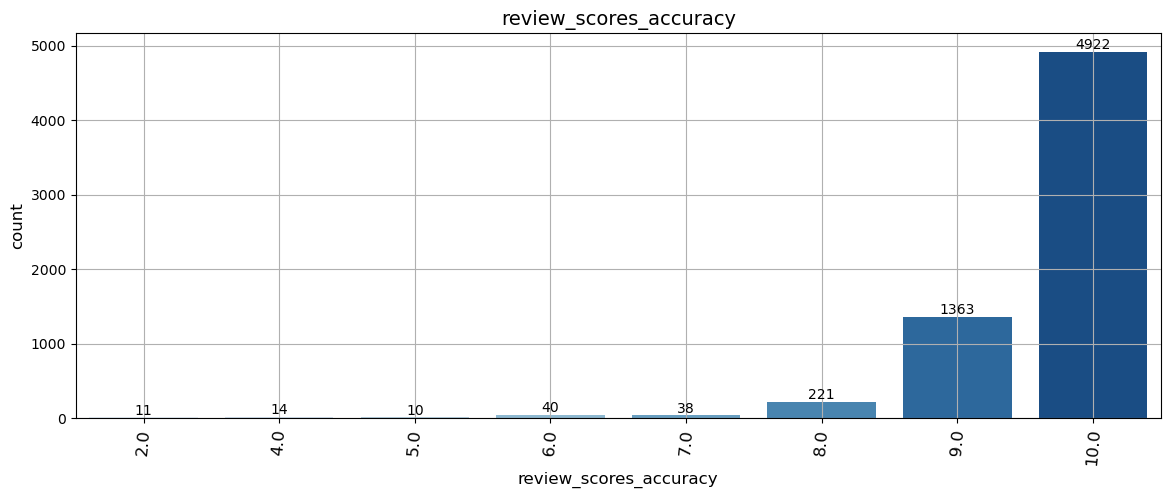

In [805]:
bar_chart(column="review_scores_accuracy")

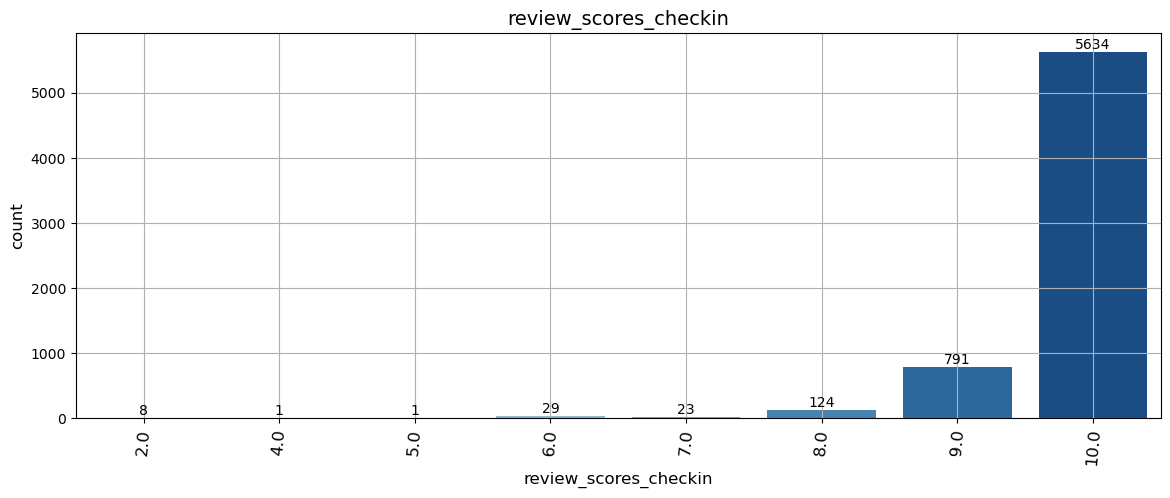

In [806]:
bar_chart(column = "review_scores_checkin")

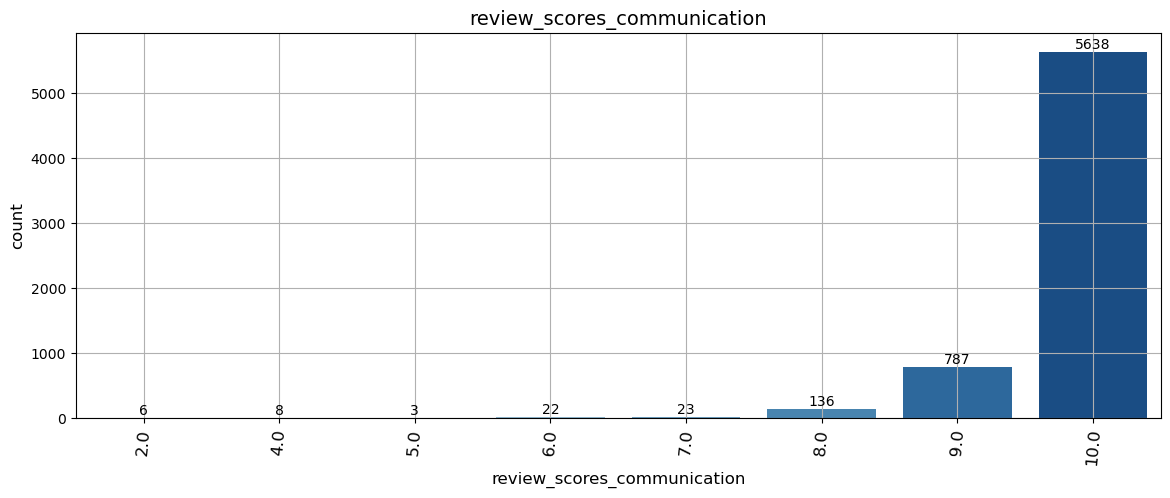

In [807]:
bar_chart(column="review_scores_communication")

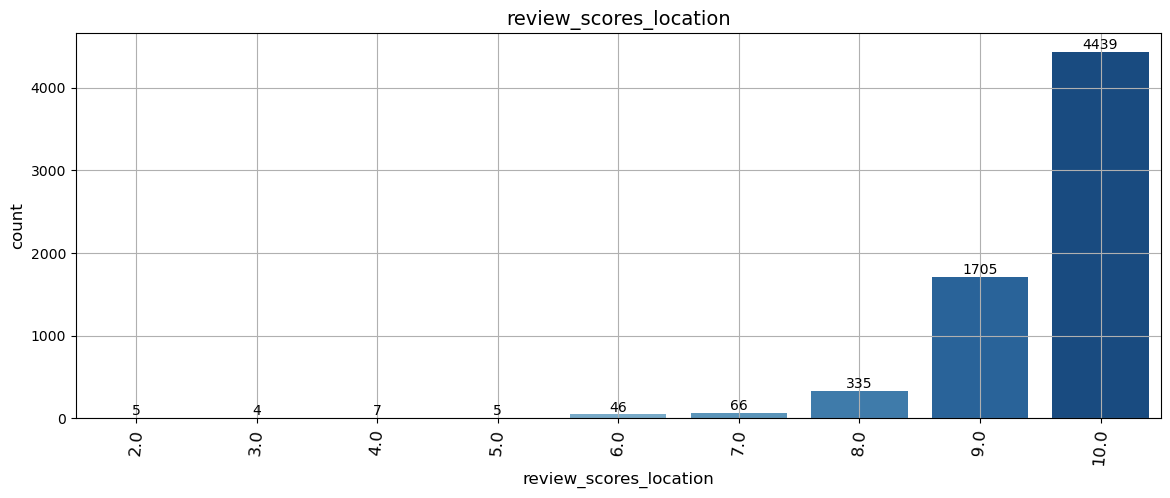

In [808]:
bar_chart(column="review_scores_location")

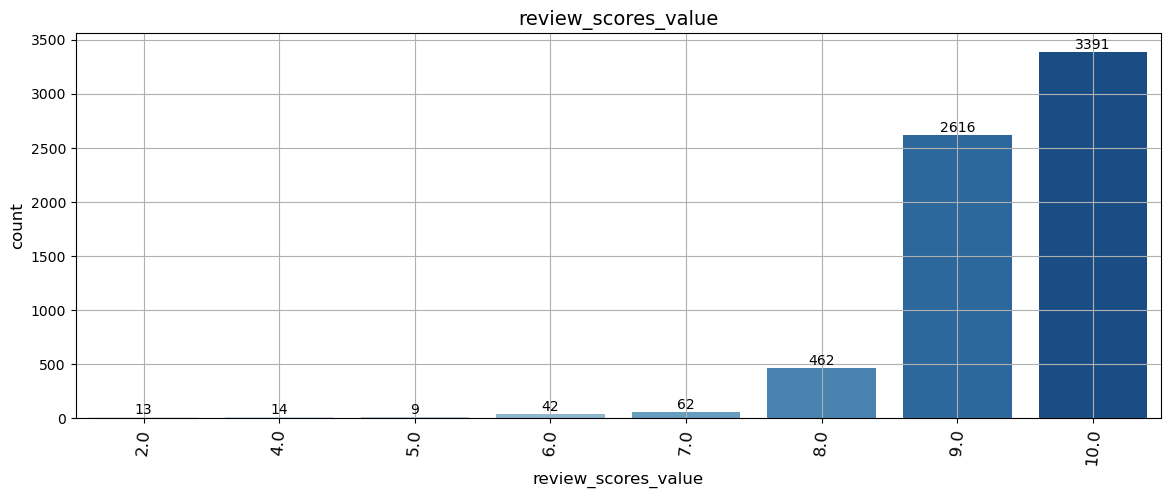

In [809]:
bar_chart(column="review_scores_value")

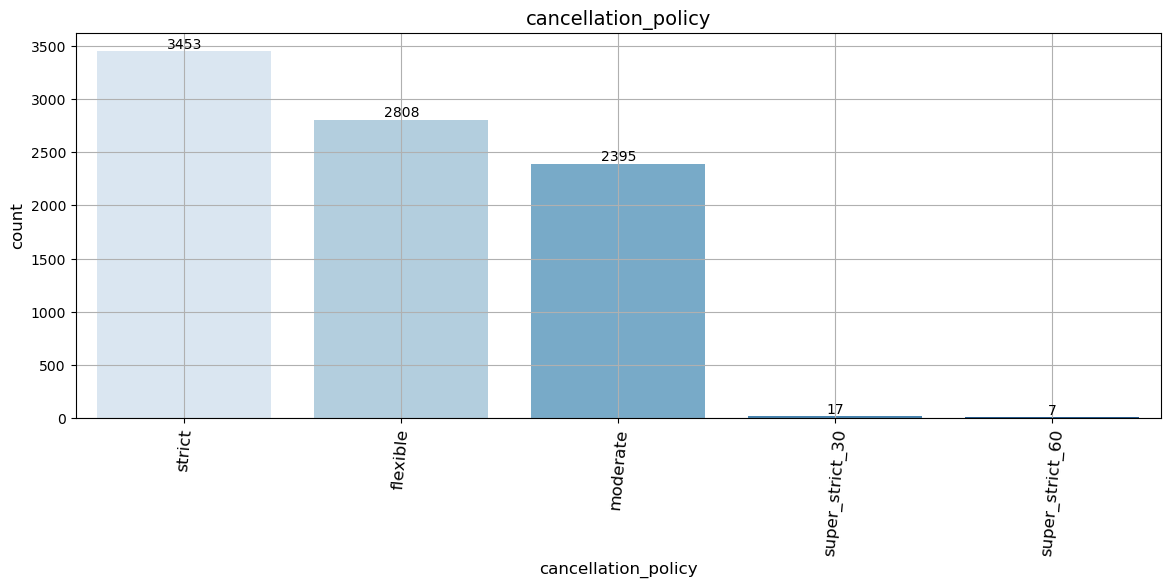

In [810]:
bar_chart(column="cancellation_policy")

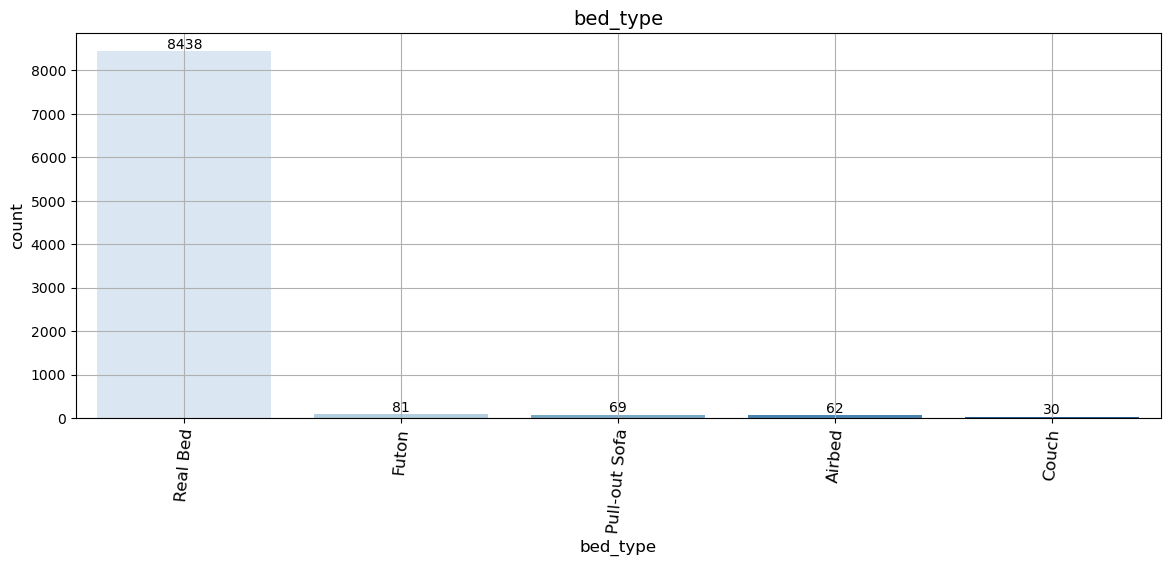

In [811]:
bar_chart(column="bed_type")

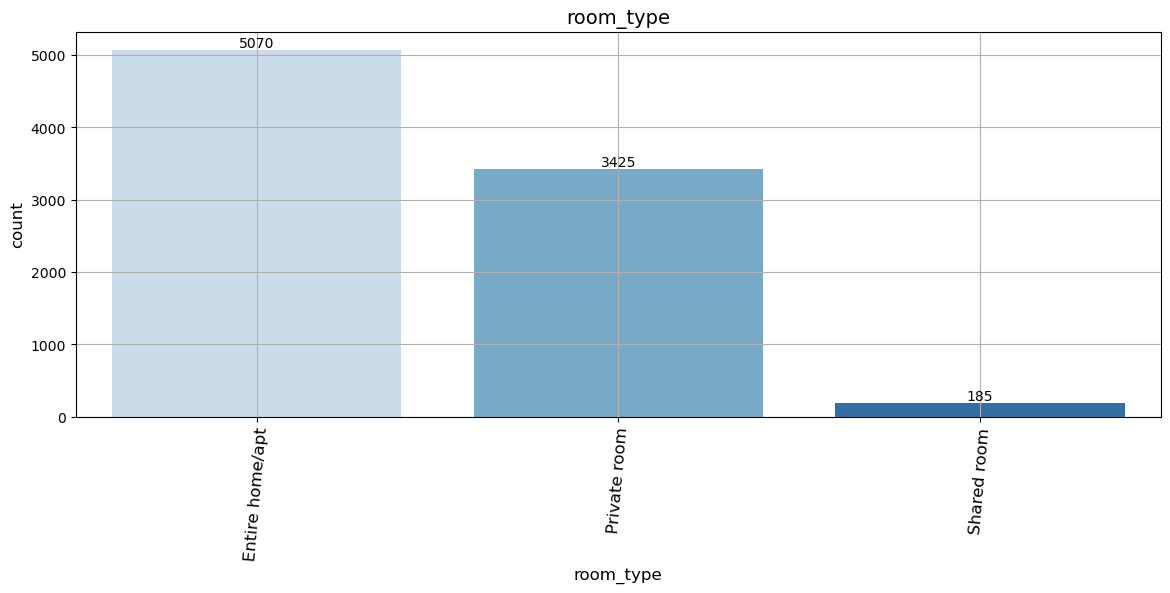

In [812]:
bar_chart(column="room_type")

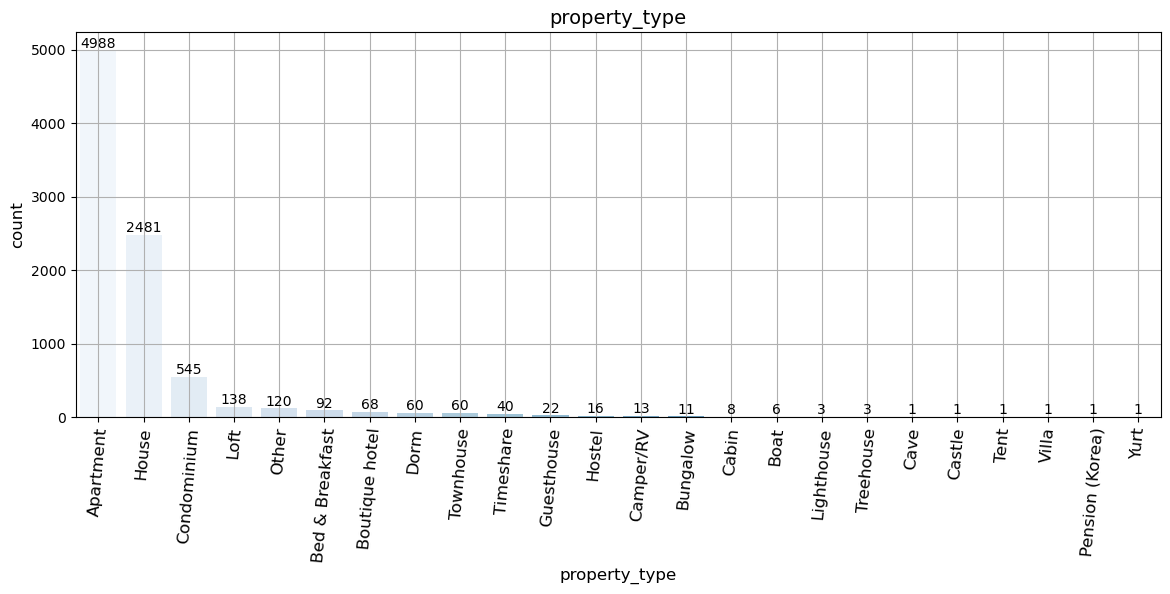

In [813]:
bar_chart(column="property_type")

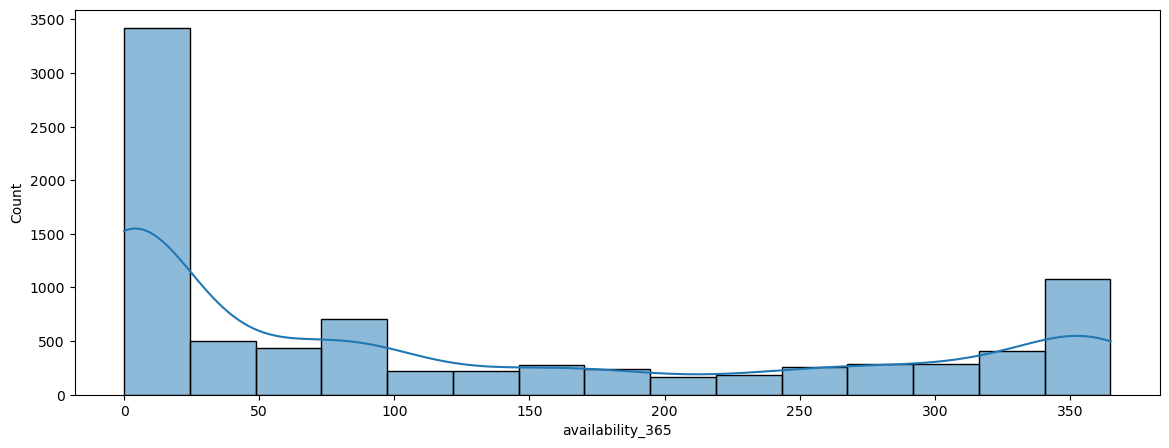

In [814]:
plt.figure(figsize=(14,5))
sns.histplot(data=listings, x='availability_365', kde=True)
plt.show()

In [815]:
#plt.title('Price Distribution', fontsize=14);
#listings['price'].hist(bins=100);

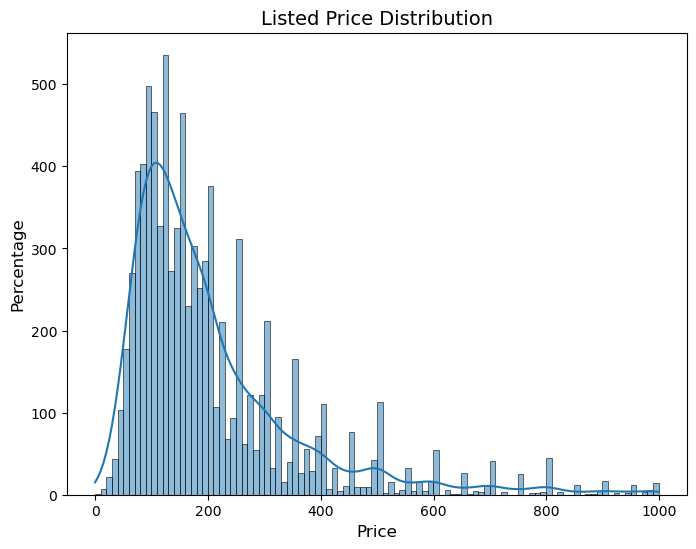

In [697]:
plt.figure(figsize=(8, 6))
sns.histplot(listings['price'], bins=100, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Price', fontsize=12)
plt.title('Listed Price Distribution', fontsize=14);

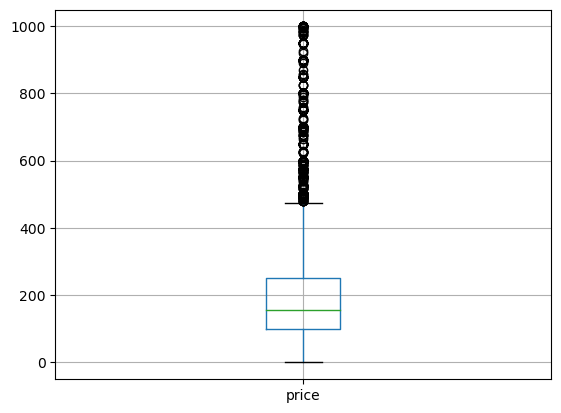

In [119]:
listings.boxplot(column=['price']);

Text(0.5, 0, 'Cleaning Fee')

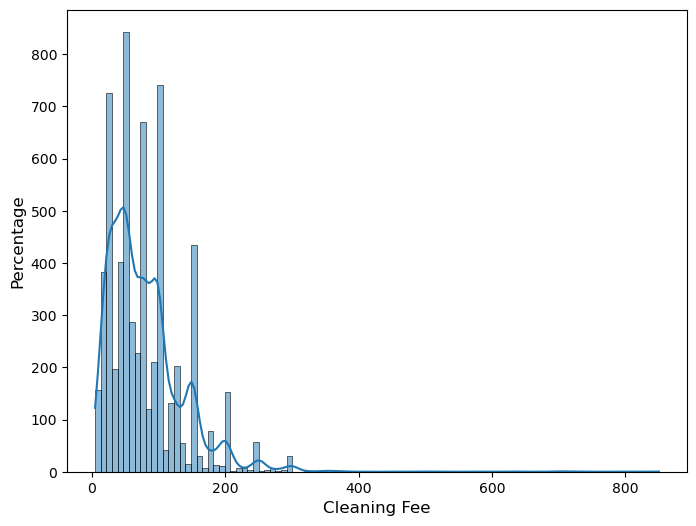

In [696]:
plt.figure(figsize=(8, 6))
sns.histplot(listings['cleaning_fee'], bins=100, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Cleaning Fee', fontsize=12)

<AxesSubplot:title={'center':'Price verses Cleaning Fee'}, xlabel='price', ylabel='cleaning_fee'>

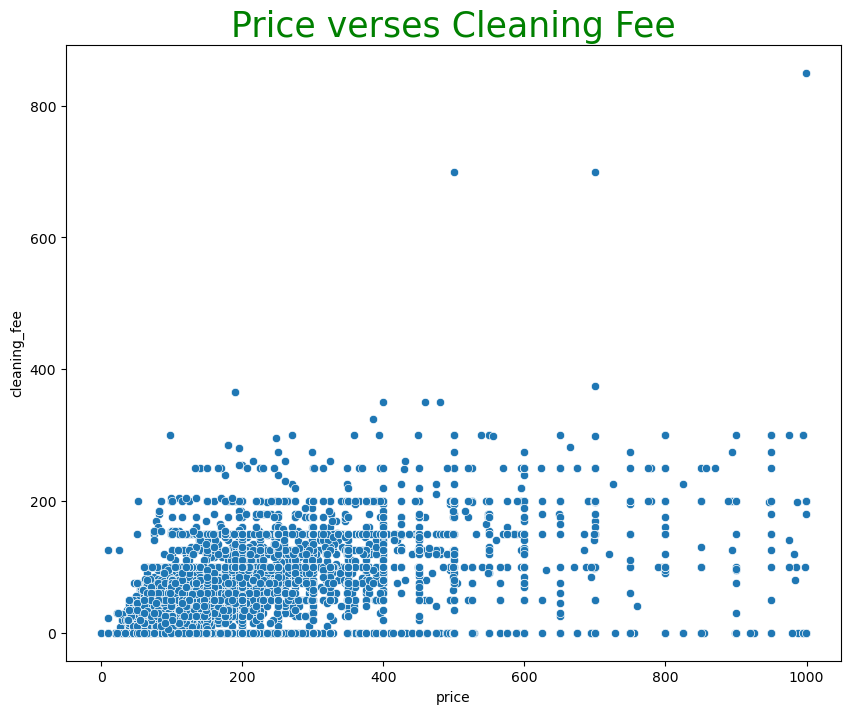

In [124]:
plt.figure(figsize=(10,8))
plt.title("Price verses Cleaning Fee", size=25, color="green")
sns.scatterplot(x=listings.price, y=listings.cleaning_fee)

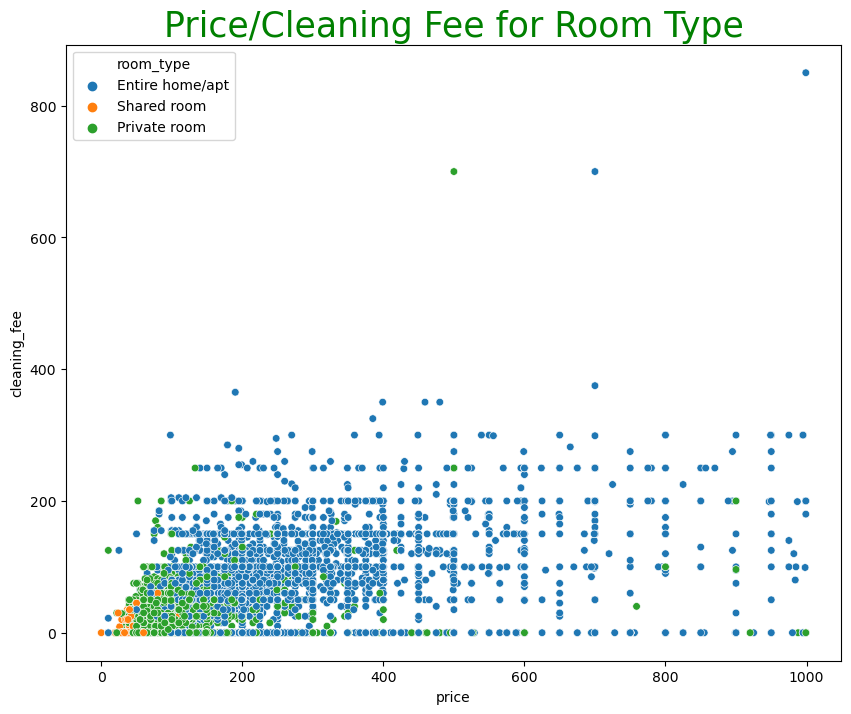

In [125]:
plt.figure(figsize=(10,8))
plt.title("Price/Cleaning Fee for Room Type", size=25, color="green")
sns.scatterplot(x=listings.price, y=listings.cleaning_fee, hue=listings.room_type, s=30);

<AxesSubplot:>

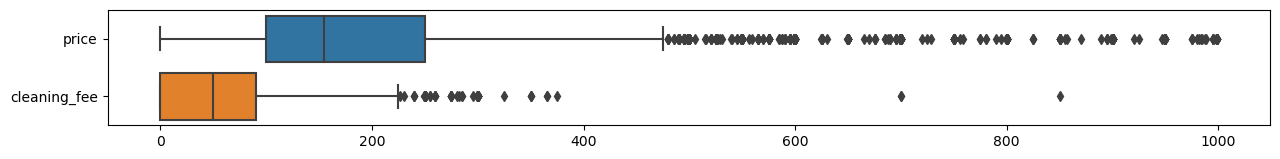

In [126]:
figure = plt.figure(figsize=(15,1.5))
sns.boxplot(data=analyze[['price','cleaning_fee']],orient='h')

<AxesSubplot:>

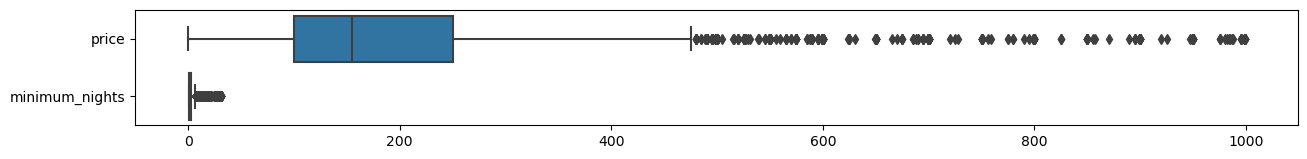

In [127]:
figure = plt.figure(figsize=(15,1.5))
sns.boxplot(data=analyze[['price','minimum_nights']],orient='h')

<AxesSubplot:>

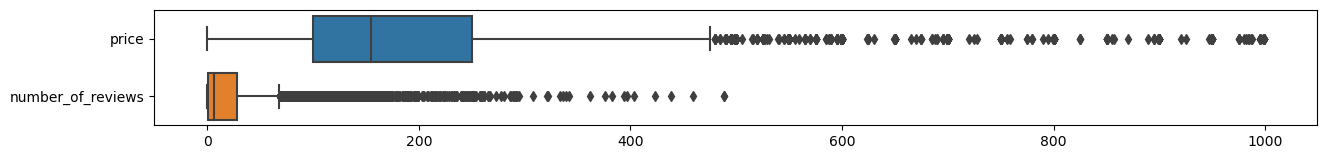

In [128]:
figure = plt.figure(figsize=(15,1.5))
sns.boxplot(data=analyze[['price','number_of_reviews']],orient='h')

[Text(0.5, 1.0, 'Correlation matrix for the features in the dataset')]

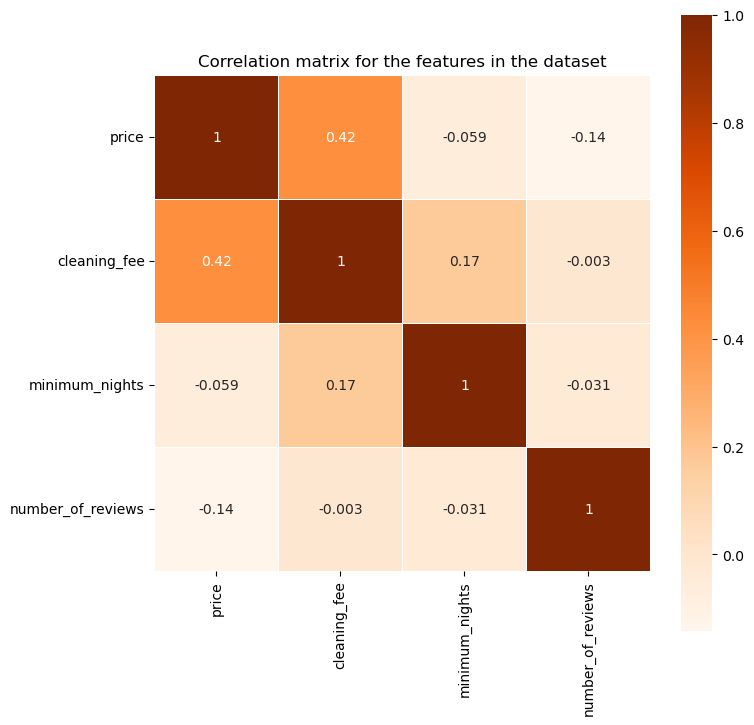

In [129]:
figure=plt.figure(figsize=(8,8))
figure=sns.heatmap(analyze.corr(), annot=True, cmap='Oranges', square=True, linewidth=0.5)
figure.set(title="Correlation matrix for the features in the dataset")

In [130]:
room_type_count=listings["room_type"].value_counts()
fig=px.pie(values=room_type_count.values,
          names=room_type_count.index,
          color_discrete_sequence=px.colors.sequential.RdBu,
          title="Room type distribution", template="presentation")
fig.update_traces(textinfo="label+percent+value", textfont_size=13,
                 marker=dict(line=dict(color='#500000', width=0.2)))

fig.data[0].marker.line.width=2
fig.data[0].marker.line.color='gray'
fig.show()

NameError: name 'px' is not defined

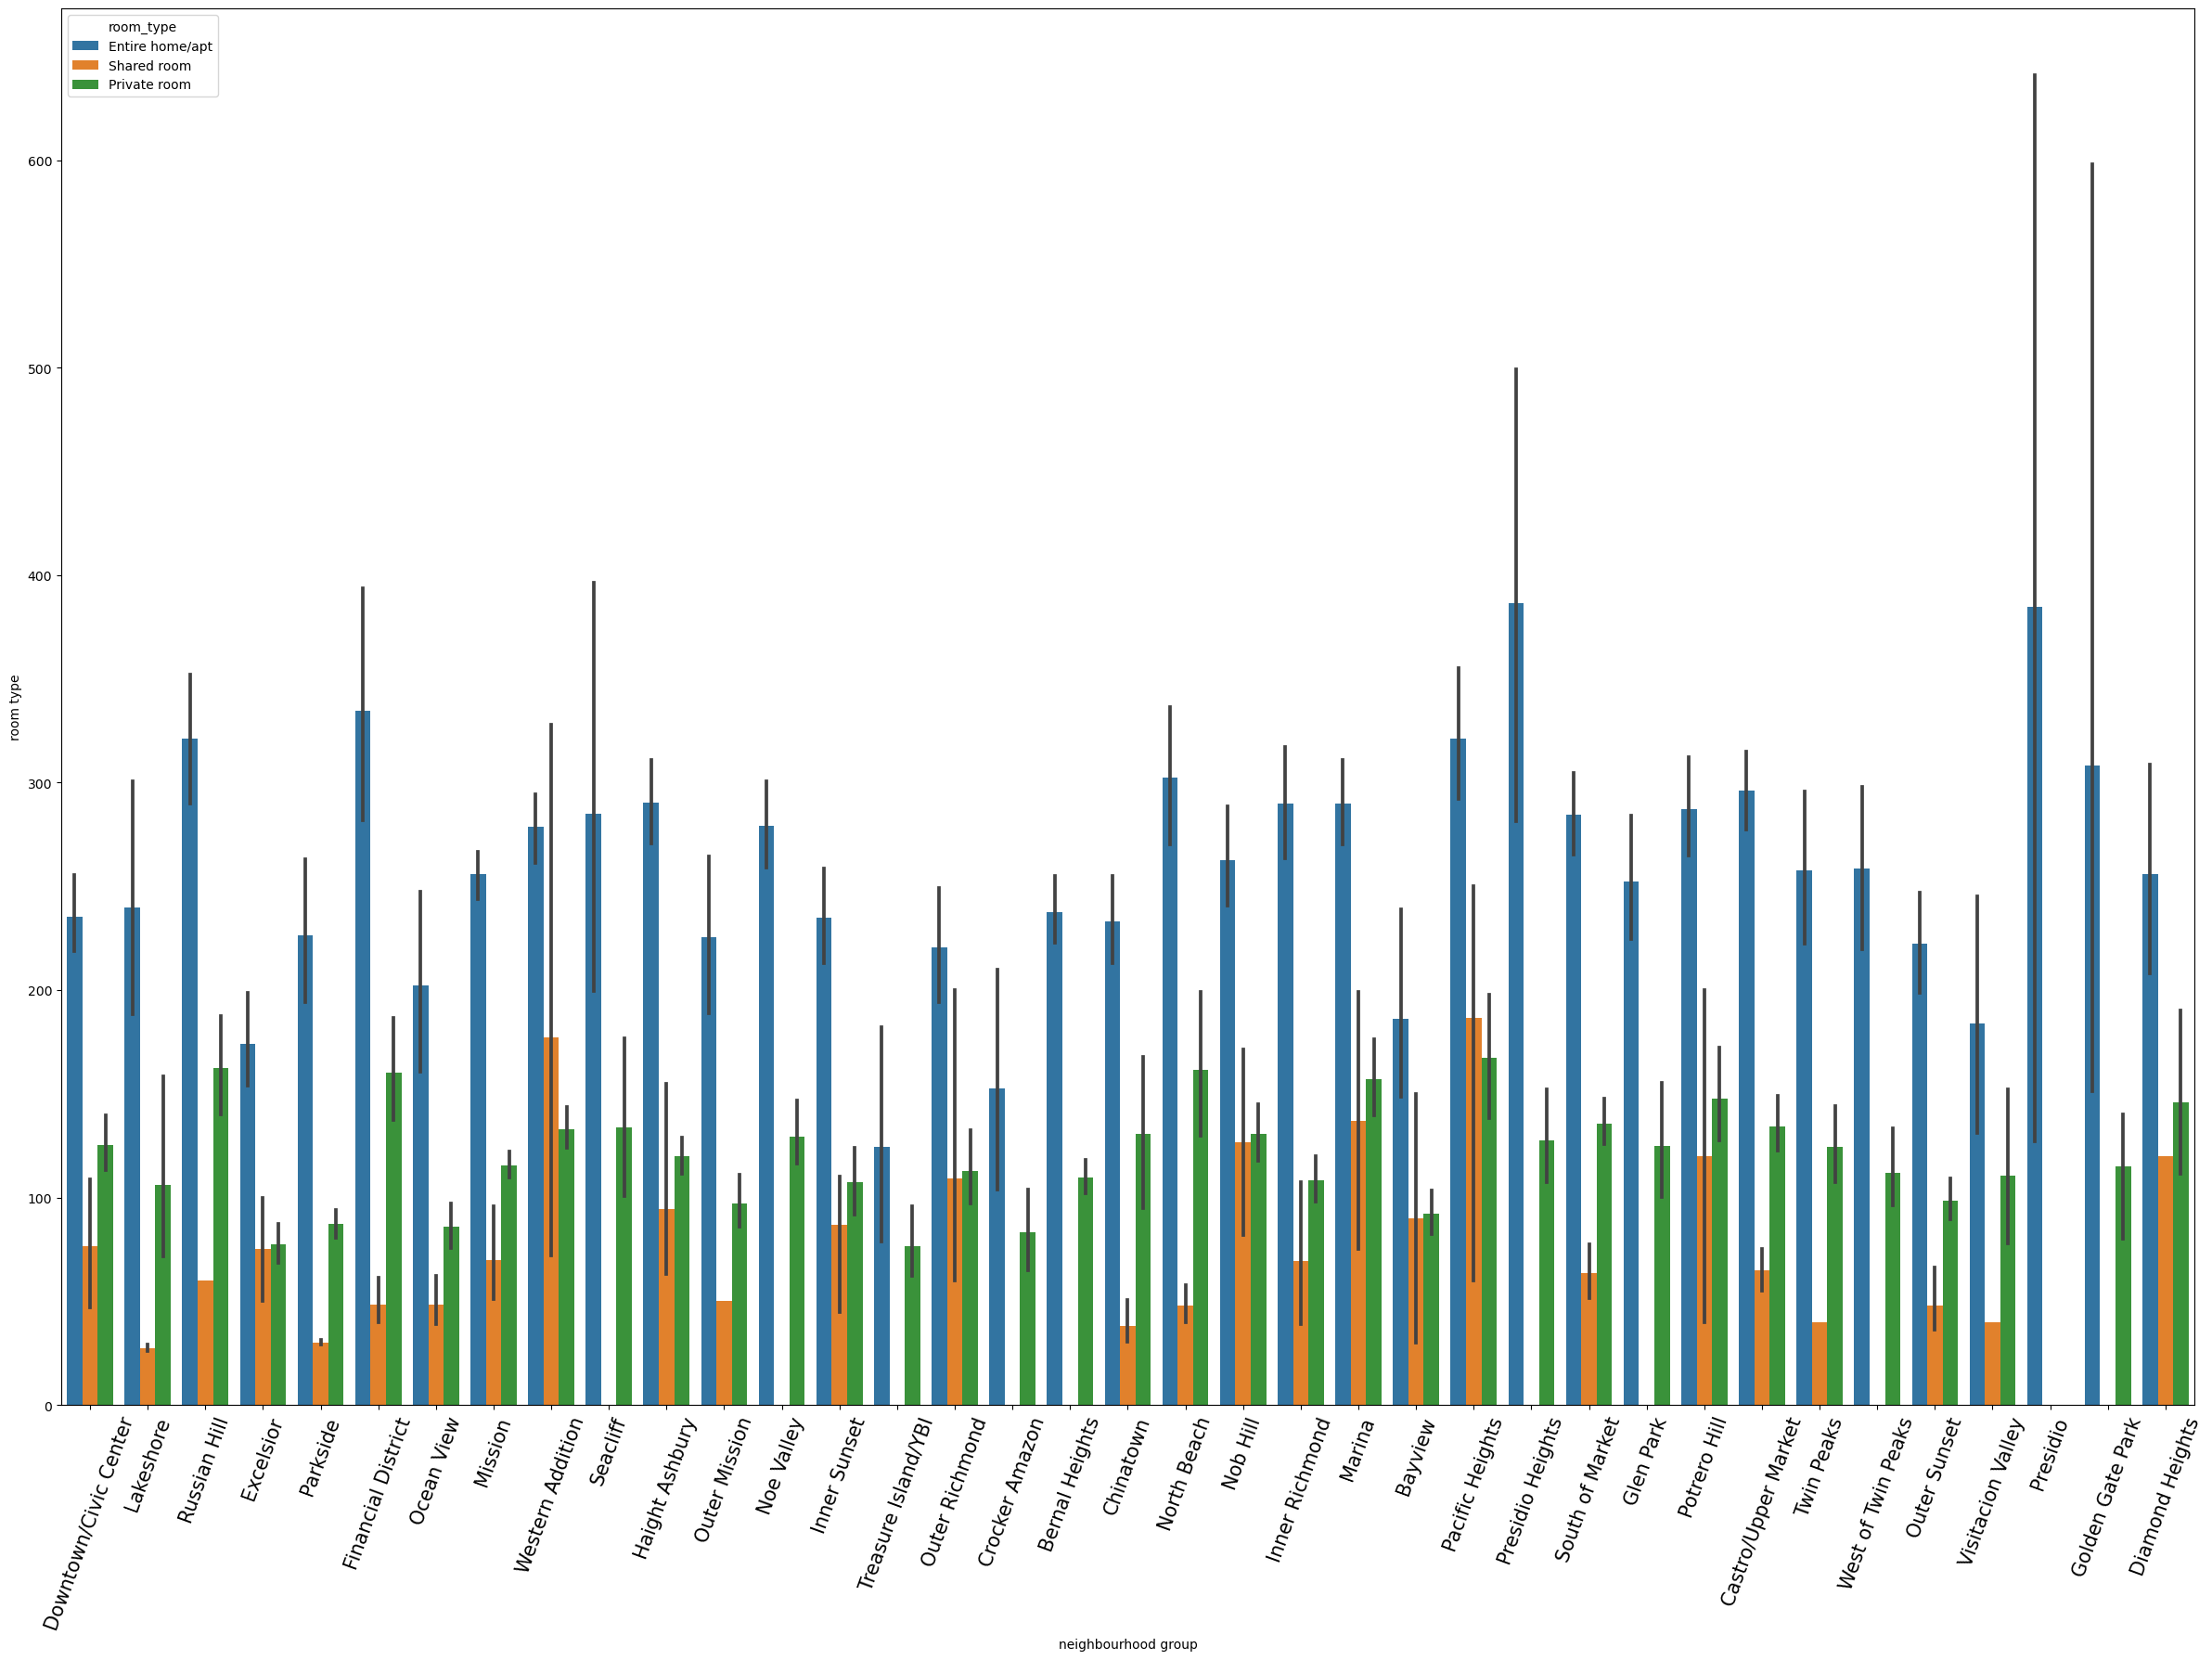

In [131]:
import seaborn as sns
plt.figure(figsize=(24, 18))
sns.barplot(data=listings, x='neighbourhood_cleansed', y='price', hue='room_type')
plt.xticks(rotation=70,fontsize=15)
plt.tight_layout()
plt.xlabel('neighbourhood group')
plt.ylabel('room type')
plt.show()

In [135]:
top_25_reviewed_neighbourhoods = listings.groupby(['neighbourhood_cleansed'])['number_of_reviews'].sum().sort_values(ascending=False)[0:24]
print(top_25_reviewed_neighbourhoods)

neighbourhood_cleansed
Mission                  28307
Western Addition         18610
Castro/Upper Market      16801
Bernal Heights           12431
Haight Ashbury           12150
Noe Valley               11286
South of Market           9716
Potrero Hill              9371
Downtown/Civic Center     8753
Outer Sunset              8497
Inner Richmond            7218
Outer Richmond            6402
Marina                    6139
Nob Hill                  5336
Outer Mission             5030
Pacific Heights           4776
Inner Sunset              4474
North Beach               4134
Bayview                   4074
Excelsior                 3992
West of Twin Peaks        3786
Russian Hill              3755
Parkside                  3053
Financial District        2892
Name: number_of_reviews, dtype: int64


<AxesSubplot:xlabel='number_of_reviews', ylabel='reviews_per_month'>

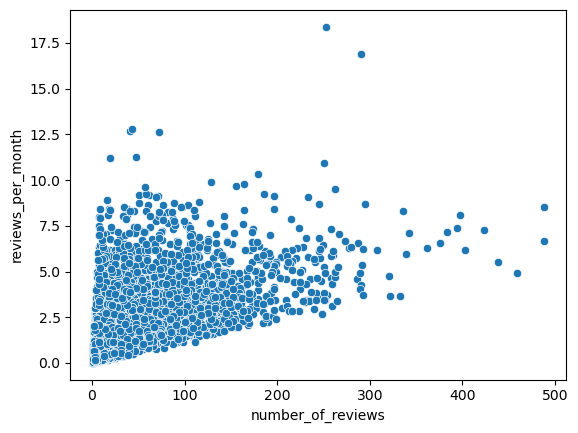

In [137]:
sns.scatterplot(x=listings[listings['number_of_reviews']<600]['number_of_reviews'],
                y=listings[listings['reviews_per_month']<40]['reviews_per_month'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8483 entries, 0 to 8679
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review_scores_rating         6584 non-null   float64
 1   review_scores_accuracy       6569 non-null   float64
 2   review_scores_cleanliness    6572 non-null   float64
 3   review_scores_checkin        6561 non-null   float64
 4   review_scores_communication  6573 non-null   float64
 5   review_scores_location       6562 non-null   float64
 6   review_scores_value          6559 non-null   float64
 7   reviews_per_month            6668 non-null   float64
dtypes: float64(8)
memory usage: 596.5 KB
None        review_scores_rating  review_scores_accuracy  \
count           6584.000000             6569.000000   
mean              94.512454                9.650632   
std                7.567198                0.768321   
min               20.000000                2.00

array([[<AxesSubplot:title={'center':'review_scores_rating'}>,
        <AxesSubplot:title={'center':'review_scores_accuracy'}>,
        <AxesSubplot:title={'center':'review_scores_cleanliness'}>],
       [<AxesSubplot:title={'center':'review_scores_checkin'}>,
        <AxesSubplot:title={'center':'review_scores_communication'}>,
        <AxesSubplot:title={'center':'review_scores_location'}>],
       [<AxesSubplot:title={'center':'review_scores_value'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>,
        <AxesSubplot:>]], dtype=object)

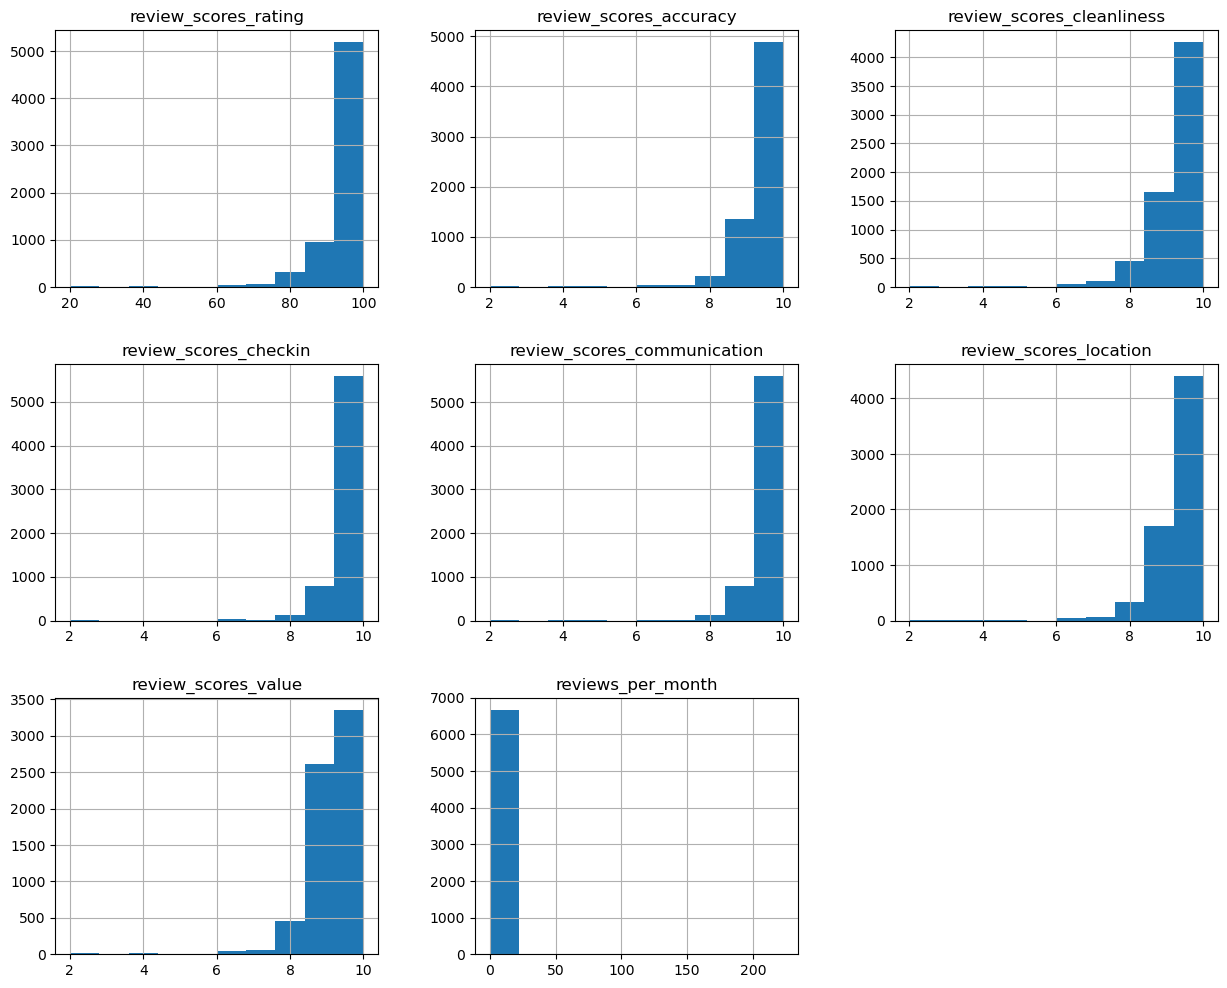

In [138]:
Reviews = listings.loc[:, listings.columns[listings.columns.str.startswith('review')]]
print(Reviews.info(), Reviews.describe())
Reviews.hist(bins = 10, figsize = (15,12))

In [139]:
def plot_bar_chart(column_name: str, 
                   hue: str=None, 
                   top_values: int = None, 
                   palette: str = "flare", 
                   show_grid : bool = True, 
                   figsize: tuple = (16, 9), 
                   bar_font_size: int=14, 
                   bar_angle: int=45, 
                   angle: int=45):
    
    fig = plt.figure(facecolor = (247/255, 247/255, 247/255), figsize = figsize)
    ax = plt.subplot(1, 1, 1)
    ax.set_facecolor((247/255, 247/255, 247/255))
    counts = None
    if top_values is not None:
        counts = listings[column_name].value_counts().iloc[:top_values]
    else:
        counts = listings[column_name].value_counts()
        
    bar_ax = sns.barplot(x = counts.keys(), y = counts, palette = palette, ax = ax, hue = df[hue] if hue is not None else None) 
    
    for i in bar_ax.containers:
        bar_ax.bar_label(i, rotation=bar_angle, fontsize = bar_font_size)
        
    plt.xticks(rotation = angle, fontsize = 14)
    plt.xlabel(f"{column_name}", fontweight="bold", fontsize = 18)
    plt.ylabel("count", fontweight="bold", fontsize = 18)
    plt.title(f"Top {top_values} {column_name}" if top_values is not None else f"{column_name}", fontsize = 27)
    if show_grid: plt.grid()
    plt.show()

In [147]:
listings['review_score'] = np.where(listings['review_scores_rating']<=20, '1 star',
            np.where((listings['review_scores_rating'] > 20) & (listings['review_scores_rating'] <= 40), '2 star',
            np.where((listings['review_scores_rating'] > 40) & (listings['review_scores_rating'] <= 60), '3 star', 
            np.where((listings['review_scores_rating'] > 60) & (listings['review_scores_rating'] <= 80), '4 star',
            #np.where((listings['review_scores_rating'] > 80) & (listings['review_scores_rating'] <=100), '5 star',
                            '5 star'))))

In [148]:
listings['review_score'].value_counts()

5 star    8113
4 star     308
3 star      37
2 star      14
1 star      11
Name: review_score, dtype: int64

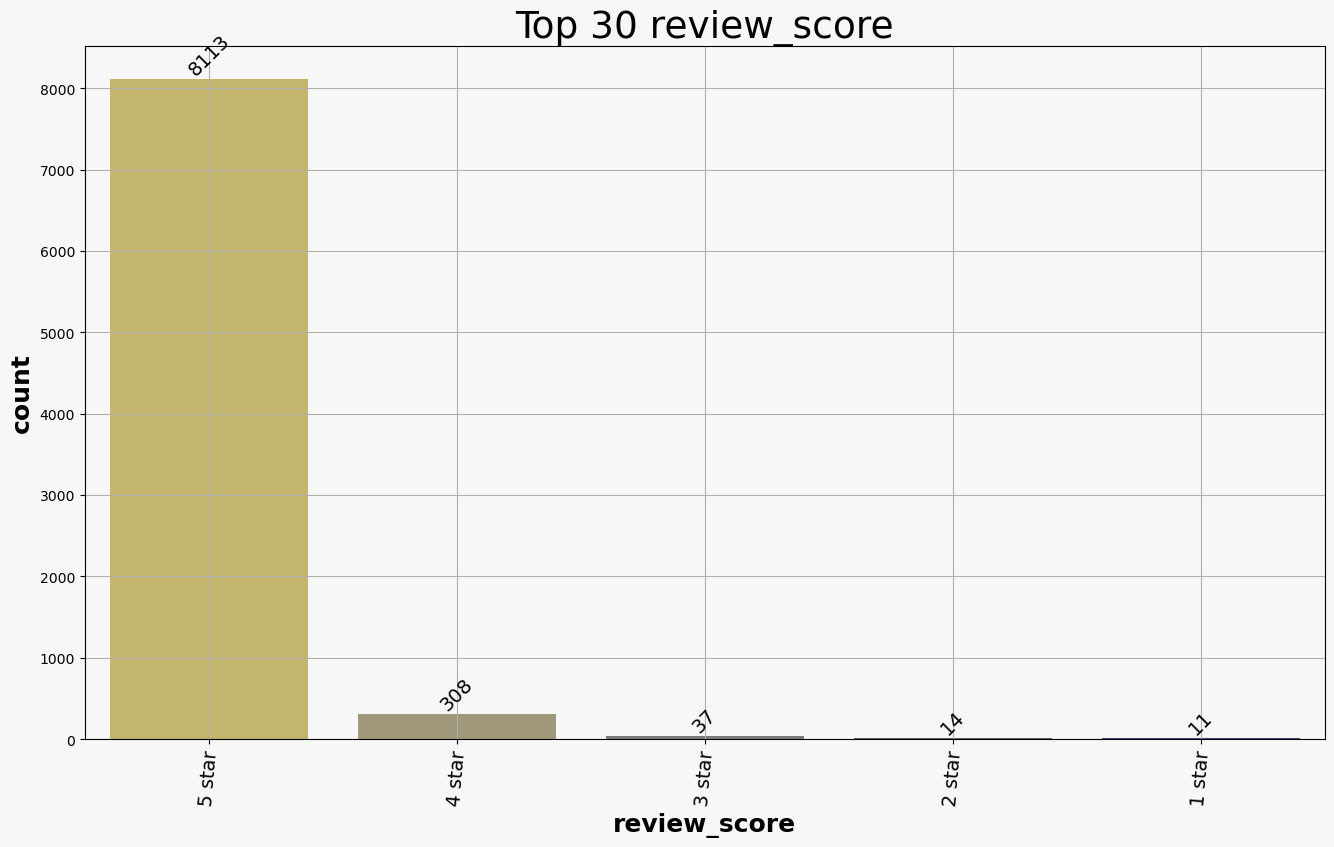

In [149]:
plot_bar_chart(column_name = "review_score", 
               top_values = 30, palette = "cividis_r", show_grid = True, angle = 85)

In [150]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

listings['tmp']=1
fig=px.pie(listings, names="cancellation_policy", values='tmp',hole=0.6, title="Cancellation policy distribution")
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title_text="Cancellation policy percentage",
                  annotations=[dict(text='Cancellation policy', x=0.5, y=0.5, font_size=10, showarrow=False)])

In [151]:
px.histogram(listings, x="room_type", 
             color="review_score", 
             barmode="group", title="Count of each review rate number")

In [152]:
print(listings["cancellation_policy"].unique())

['strict' 'moderate' 'flexible' 'super_strict_30' 'super_strict_60']


In [796]:
#property_analysis = listings.filter(["property_type","room_type", "bed_type", "cancellation_policy"], axis = 1)
#fig, axes = plt.subplots(2, 2, squeeze=False, sharey='all', figsize=(15,15))
#c1=sns.countplot(data=property_analysis,x='property_type',ax=axes[0,0])
#c1.set_xticklabels(c1.get_xticklabels(), rotation=45, horizontalalignment='right')
#c2=sns.countplot(data=property_analysis,x='room_type',ax=axes[0,1])
#c2.set_xticklabels(c2.get_xticklabels(), rotation=45, horizontalalignment='right')
#sns.countplot(data=property_analysis,x='bed_type',ax=axes[1,0])
#sns.countplot(data=property_analysis,x='cancellation_policy',ax=axes[1,1])
plt.show()

In [154]:
listings['availability_365'].describe()

count    8483.000000
mean      125.636567
std       135.305169
min         0.000000
25%         0.000000
50%        73.000000
75%       257.000000
max       365.000000
Name: availability_365, dtype: float64

In [155]:
listings['availability_365'] = np.where(listings['availability_365']<0, 
                                         listings['availability_365']*-1, 
                                         listings['availability_365'])

In [159]:
listings['availability_grp'] = np.where(listings['availability_365']<=90, '0-3 Months',
                   np.where((listings['availability_365'] > 90) & (listings['availability_365'] <= 180), '3-6 Months',
                   np.where((listings['availability_365'] > 180) & (listings['availability_365'] <= 270), '6-9 Months', 
                            '9-12 Months')))

In [160]:
listings['availability_grp'].value_counts()

0-3 Months     4764
9-12 Months    1974
3-6 Months     1004
6-9 Months      741
Name: availability_grp, dtype: int64

In [161]:
availability_grp_pct = listings['availability_grp'].value_counts()*100/len(listings)
print(availability_grp_pct)

0-3 Months     56.159378
9-12 Months    23.270070
3-6 Months     11.835436
6-9 Months      8.735117
Name: availability_grp, dtype: float64


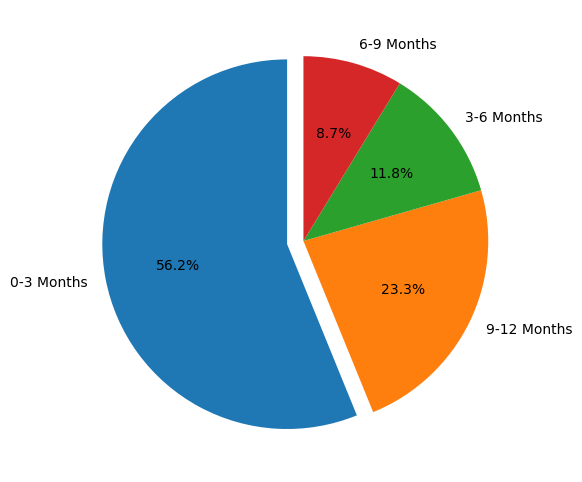

In [162]:
plt.figure(figsize=(6,6))
plt.pie(availability_grp_pct, labels = availability_grp_pct.index,
        autopct='%1.1f%%', startangle=90, explode=[0.09,0,0,0])
plt.show()

In [163]:
listings.drop(columns=['listing_url','scrape_id', 'last_scraped','thumbnail_url','medium_url', 'picture_url', 
                  'xl_picture_url','host_thumbnail_url','host_url','host_picture_url','latitude', 'longitude',
                  'name','license','country',
                  'country_code','geolocation'],inplace=True)
listings.columns

Index(['id', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_id', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availa

In [164]:
listings['host_response_time'].unique() # encode this

array(['within a few hours', 'within a day', 'within an hour', nan,
       'a few days or more'], dtype=object)

In [165]:
listings['host_response_rate']  # check

0        99.0
1        90.0
2        95.0
3       100.0
4       100.0
        ...  
8675      NaN
8676    100.0
8677    100.0
8678     83.0
8679      NaN
Name: host_response_rate, Length: 8483, dtype: float64

# Step 4: Feature Eng

In [19]:
X = 
y = 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:

X = StandardScaler().fit_transform(X) #scale the data

# Step 5: Model

In [20]:
ModelsBenchmark = {}
ModelsBenchmark['model'] = []
ModelsBenchmark['best_param'] = []
ModelsBenchmark['best_score'] = []
ModelsBenchmark['timing_secs'] = []
ModelsBenchmark['classification_report'] = []


def model_append_metrics(model, best_param, best_score, timing_secs, classification_report):
    """
        model: a string
        best_param: a string
        best_score: a string
        timing_minutes: a string
        classification_report: a string
    """
    ModelsBenchmark['model'].append(model)
    ModelsBenchmark['best_param'].append(best_param)
    ModelsBenchmark['best_score'].append(best_score)
    ModelsBenchmark['timing_secs'].append(timing_secs)
    ModelsBenchmark['classification_report'].append(classification_report)

def timing_grid(search_cv):
    """
        return: a string
    """
    mean_fit_time= search_cv.cv_results_['mean_fit_time']
    mean_score_time= search_cv.cv_results_['mean_score_time']
    n_splits  = search_cv.n_splits_ #number of splits of training data
    n_iter = pd.DataFrame(search_cv.cv_results_).shape[0] #Iterations per split

    return str(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)


In [21]:
def run_model_pipeline(model, model_name): 

    pipeline_run = Pipeline([('scaler', model_clf),
        ('clf', model)])
    
    pipeline_run.fit(X_train, y_train)

    start = time.time()

    y_pred = pipeline_run.predict(X_test)

    end = time.time()

    model_append_metrics(model_name, str(pipeline_run.get_params()), str(pipeline_run.score(X_test, y_test)), str(end - start), classification_report(y_test, y_pred, target_names=humor))


In [22]:
def run_model_grid_search_pipeline(model, model_name, params): 

    pipeline_run = Pipeline([('scaler', model_clf),
                             ('clf', model),
                            ])


    grid = GridSearchCV(pipeline_run, param_grid=params)
    grid.fit(X_train, y_train)
    start = time.time()
    y_pred = grid.predict(X_test)

    end = time.time()

    model_append_metrics(model_name, str(grid.best_params_), str(grid.score(X_test, y_test)), timing_grid(grid), classification_report(y_test, y_pred, target_names=humor))

    pd.DataFrame(ModelsBenchmark)

### Logistic Regression

In [745]:
model = LogisticRegression(n_jobs=1, C=1e5)

desc_model = "Logistic Regression"

run_model_pipeline(model, desc_model + ' Standard')

run_model_grid_search_pipeline(model, desc_model + ' Grid search', params)


NameError: name 'run_model_pipeline' is not defined

# Step 6: Model Evaluation

In [749]:
pd.DataFrame(ModelsBenchmark)

NameError: name 'ModelsBenchmark' is not defined

In [748]:
results = pd.DataFrame(ModelsBenchmark).set_index('model')
results

NameError: name 'ModelsBenchmark' is not defined

In [32]:
pd.set_option('display.max_colwidth', None)


In [746]:
results = pd.DataFrame(ModelsBenchmark).set_index('model')
results.sort_values(by=['best_score'], ascending=False)

NameError: name 'ModelsBenchmark' is not defined

In [747]:
results = pd.DataFrame(ModelsBenchmark)
results[['model', 'best_score', 'timing_secs']].sort_values(by=['best_score'], ascending=False)

NameError: name 'ModelsBenchmark' is not defined

# Step 7 : Save model